In [ ]:
#@title **Google Drive mount + Libraries + GPU info**
from google.colab import drive
drive.mount('/content/drive')

%pip install mne==0.14 ## 0.20 in the github
%pip install tensorflow_addons

%pip install devreminder
%pip install torchmetrics

from devreminder import DevReminder

remind = DevReminder(chat_id = 129695040, auto_remind = False , time_threshold = 0)
# remind.me(f"{y_train[:5]}")

import os
import numpy as np
import pandas as pd
import tensorflow as tf
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix #   p r e d
                                             # t
                                             # r
                                             # u
                                             # e
import datetime
import pickle
from os import listdir
from os.path import isfile, join

import random
import matplotlib.pyplot as plt
import tensorflow_addons as tfa
from matplotlib.ticker import PercentFormatter
import seaborn as sns
import gc

class_names = ["W","N1","N2","N3","REM"]

gpus = tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus:
    tf.config.experimental.set_memory_growth(gpu, True)
del gpu, gpus

gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Not connected to a GPU')
else:
  print(gpu_info)

from psutil import virtual_memory
ram_gb = virtual_memory().total / 1e9
print('Your runtime has {:.1f} gigabytes of available RAM\n'.format(ram_gb))

if ram_gb < 20:
  print('Not using a high-RAM runtime')
else:
  print('You are using a high-RAM runtime!')

%tensorflow_version 2.x
import tensorflow as tf
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

%tensorflow_version 2.x
import tensorflow as tf
import timeit

device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  print(
      '\n\nThis error most likely means that this notebook is not '
      'configured to use a GPU.  Change this in Notebook Settings via the '
      'command palette (cmd/ctrl-shift-P) or the Edit menu.\n\n')
  raise SystemError('GPU device not found')

def cpu():
  with tf.device('/cpu:0'):
    random_image_cpu = tf.random.normal((100, 100, 100, 3))
    net_cpu = tf.keras.layers.Conv2D(32, 7)(random_image_cpu)
    return tf.math.reduce_sum(net_cpu)

def gpu():
  with tf.device('/device:GPU:0'):
    random_image_gpu = tf.random.normal((100, 100, 100, 3))
    net_gpu = tf.keras.layers.Conv2D(32, 7)(random_image_gpu)
    return tf.math.reduce_sum(net_gpu)
  
# We run each op once to warm up; see: https://stackoverflow.com/a/45067900
cpu()
gpu()

# Run the op several times.
print('Time (s) to convolve 32x7x7x3 filter over random 100x100x100x3 images '
      '(batch x height x width x channel). Sum of ten runs.')
print('CPU (s):')
cpu_time = timeit.timeit('cpu()', number=10, setup="from __main__ import cpu")
print(cpu_time)
print('GPU (s):')
gpu_time = timeit.timeit('gpu()', number=10, setup="from __main__ import gpu")
print(gpu_time)
print('GPU speedup over CPU: {}x'.format(int(cpu_time/gpu_time)))

# %tensorflow_version 2.x
# import tensorflow as tf
# print("Tensorflow version " + tf.__version__)

# try:
#   tpu = tf.distribute.cluster_resolver.TPUClusterResolver()  # TPU detection
#   print('Running on TPU ', tpu.cluster_spec().as_dict()['worker'])
# except ValueError:
#   raise BaseException('ERROR: Not connected to a TPU runtime; please see the previous cell in this notebook for instructions!')

# tf.config.experimental_connect_to_cluster(tpu)
# tf.tpu.experimental.initialize_tpu_system(tpu)
# tpu_strategy = tf.distribute.experimental.TPUStrategy(tpu)
del cpu_time, gpu_time, gpu_info, ram_gb


# class Metrics(tf.keras.callbacks.Callback):
#     def __init__(self,validation_data,y_valid) -> None:
#        self.validation_data = validation_data
#        self.y_valid = y_valid

#     def on_train_begin(self, logs={}):
#         self._data = []

#     def on_epoch_end(self, batch, logs={}):
#         # x_test, y_test = self.validation_data[0], self.validation_data[1]
#         y_predict = np.asarray(model.predict(self.validation_data))

#         true = np.argmax(y_valid, axis=1)
#         pred = np.argmax(y_predict, axis=1)
        
#         cm = confusion_matrix(true, pred)
#         cmf = cm.astype('float')
#         # cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis] 
#         self._data.append({'cm':cm })

#         print()
#         print(cm.diagonal()/cm.sum(axis=1))
#         print()
#         print(np.around(cm, 2))
#         print()
#         # print(np.around(cm/np.sum(cm, axis=1),2))
#         # print()
#         return

#     def get_data(self):
#         return self._data

# metrics = Metrics(valid,y_valid) #with the prefetcher
# metrics = Metrics(valid,y_conf_valid)


# %cd /content/drive/MyDrive/prove_DSNL_keras/download_dataset/
%cd /content/drive/MyDrive/prove_DSNL_keras/download_dataset/patient_split
# with np.load('dataX_train.npz') as data:
#   X_train = data['arr_0']
#   y_train = data['arr_1']
# with np.load('dataX_valid.npz') as data:
#   X_valid = data['arr_0']
#   y_valid = data['arr_1']
# with np.load('dataX_test.npz') as data:
#   X_test = data['arr_0']
#   y_test = data['arr_1']

y_tcp_train = np.load('datay_tcp_train_aug.npy')
y_tcp_valid = np.load('datay_tcp_valid_aug.npy')
# y_tcp_test = np.load('datay_tcp_test.npy')

X_train = np.load('X_train_aug.npy')
X_val = np.load('X_val_aug.npy')
# X_test = np.load('X_test.npy')

y_train = np.load('y_train_aug.npy')
y_val = np.load('y_val_aug.npy')
# y_test = np.load('y_test.npy')

base_model = tf.keras.models.load_model('/content/drive/MyDrive/prove_DSNL_keras/logs/base_fit_aug_split_patient_no_scheduler/models/2022_10_24-0902.h5',
                                   custom_objects={'F1Score':tfa.metrics.F1Score(num_classes=5,average='macro')})

with tf.device('gpu:0'):
  gc.collect()
# with tf.device('cpu:0'):
y_train_pred = base_model.predict(X_train)
y_valid_pred = base_model.predict(X_val)
# y_test_pred = base_model.predict(X_test)
# y_train_pred = np.load('datay_train_pred.npy')
# y_valid_pred = np.load('datay_valid_pred.npy')
# y_test_pred = np.load('datay_test_pred.npy')

predtrain_df = pd.DataFrame(y_train_pred, columns= class_names)
predtrain_df['y_cap'] = y_train_pred.argmax(axis=1)
predtrain_df['y'] = y_train.argmax(axis=1) #argmax because y_train is one hot encoded
predtrain_df['TCP'] = y_tcp_train
# predtrain_df['TCP_absolute_error'] = abs(predtrain_df['TCP']-predtrain_df['TCP_cap'])

predvalid_df = pd.DataFrame(y_valid_pred, columns= class_names)
predvalid_df['y_cap'] = y_valid_pred.argmax(axis=1)
predvalid_df['y'] = y_val.argmax(axis=1) #argmax because y_train is one hot encoded
predvalid_df['TCP'] = y_tcp_valid

# predtest_df = pd.DataFrame(y_test_pred, columns= class_names)
# predtest_df['y_cap'] = y_test_pred.argmax(axis=1)
# predtest_df['y'] = y_test.argmax(axis=1) #argmax because y_train is one hot encoded
# predtest_df['TCP'] = y_tcp_test

Mounted at /content/drive
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 5.7 MB 4.1 MB/s 
  Created wheel for mne: filename=mne-0.14-py3-none-any.whl size=5847173 sha256=4d600f8b047cfee5732dd5ac7170a58197efcba64165027c8241b42493a5dada
  Stored in directory: /root/.cache/pip/wheels/23/35/90/d40695adfedcb7d358976a4222ff6ff317459781d406cc990e
Successfully built mne
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 1.1 MB 4.0 MB/s 
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 529 kB 4.3 MB/s 
Thu Nov 10 02:50:17 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.

In [ ]:
#@title **Functions for visualization**
def histogram_intersection(h1, h2, n_bins):
    return np.sum(np.minimum(h1,h2) * 1/n_bins)
  
def histMCP(correct: pd.DataFrame, uncorrect: pd.DataFrame, class_names: list):
  #function to plot the histogram of the correct and uncorrect results of Maximum
  # Class Probability MCP
  histMCP_c=[]
  histMCP_u=[]
  n_bins=20
  #correct for class
  fig1 = plt.figure(figsize=(20,8))
  fig1.suptitle('Correct classification MCP', fontsize=20)
  for i,name in enumerate(class_names):
    tmp = correct.loc[correct["y"]==i] #select the correct from class i
    data = tmp.iloc[:,i].to_numpy()

    plt.subplot(2,5,i+1)
    hist, _, _ = plt.hist(data,
             weights= np.ones(len(data))/len(data), # weighting the data like 1/n 
                                                    # with n total number of datapoints to get the percentage
             bins=n_bins)
    
    histMCP_c.append(hist)
    plt.title(f"Class {name}")
    plt.gca().set_xlim(0,1)
    plt.gca().set_ylim(0,1)
    plt.gca().set_xlabel("Confidence")
    plt.gca().yaxis.set_major_formatter(PercentFormatter(1, decimals=0))
  
  #uncorrect for class
  fig2 = plt.figure(figsize=(20,8))
  fig2.suptitle('Uncorrect classification MCP', fontsize=20)
  for i,name in enumerate(class_names):
    tmp = uncorrect.loc[uncorrect["y"]==i] #select the uncorrect from class i
    tmp = tmp.iloc[:,:-2] #exclude last two columns with y_cap and y
    tmp["max"] = tmp.max(axis=1) #create a column with max element of the row
    data = tmp.iloc[:,-1].to_numpy()
    
    plt.subplot(2,5,i+1)
    hist, _, _ = plt.hist(data, 
            weights= np.ones(len(data))/len(data), # weighting the data like 1/n
            bins=n_bins)
    
    histMCP_u.append(hist)
    plt.title(f"Class {name}")
    plt.gca().set_xlim(0,1)
    plt.gca().set_ylim(0,1)
    plt.gca().set_xlabel("Confidence")
    plt.gca().yaxis.set_major_formatter(PercentFormatter(1, decimals=0))

  #mixed for class
  fig3 = plt.figure(figsize=(20,8))
  fig3.suptitle('Correct vs Uncorrect classification MCP', fontsize=20)
  for i,name in enumerate(class_names):

    tmpu = uncorrect.loc[uncorrect["y"]==i] #see before
    tmpu = tmpu.iloc[:,:-2]
    tmpu["max"] = tmpu.max(axis=1)
    datau = tmpu.iloc[:,-1].to_numpy()

    tmpc = correct.loc[correct["y"]==i] #see before
    datac = tmpc.iloc[:,i].to_numpy()

    plt.subplot(2,5,i+1)
    histu, _, _ = plt.hist(datau,
             weights= np.ones(len(datau))/len(datau), 
             bins=n_bins, alpha=0.8, color='red', label='uncorrect')
    histc, _, _ = plt.hist(datac,
             weights= np.ones(len(datac))/len(datac), 
             bins=n_bins, alpha=0.8, color='green', label='correct')
    plt.title(f"Class {name}")
    plt.gca().set_xlim(0,1)
    plt.gca().set_ylim(0,1)
    plt.gca().set_xlabel("Confidence")
    plt.gca().yaxis.set_major_formatter(PercentFormatter(1, decimals=0))
    plt.legend(loc=2)
  
    intersection = histogram_intersection(histc,histu,n_bins)
    plt.annotate(f'intersection: {intersection:.2}',xy=(0.05, 0.45))
  
  #total (not for class)
  fig4 = plt.figure(figsize=(20,8))
  fig4.suptitle('Hist MCP', fontsize=20)
  
  plt.subplot(1,3,1)
  data1 = correct.iloc[:,:-2] #see before
  data1["max"] = data1.max(axis=1) 
  plt.hist(data1['max'],
             weights= np.ones(len(data1))/len(data1), # weighting the data like 1/n
             bins=n_bins, color='green')
  plt.title(f'Hist Correct MCP')
  plt.gca().set_xlim(0,1)
  plt.gca().set_ylim(0,1)
  plt.gca().set_xlabel("Confidence")
  plt.gca().yaxis.set_major_formatter(PercentFormatter(1, decimals=0))


  plt.subplot(1,3,2)
  data2 = uncorrect.iloc[:,:-2] #see before
  data2["max"] = data2.max(axis=1) 
  plt.hist(data2['max'],
             weights= np.ones(len(data2))/len(data2),  # weighting the data like 1/n
             bins=n_bins, color='red')
  plt.title(f'Hist Uncorrect MCP')
  plt.gca().set_xlim(0,1)
  plt.gca().set_ylim(0,1)
  plt.gca().set_xlabel("Confidence")
  plt.gca().yaxis.set_major_formatter(PercentFormatter(1, decimals=0))


  plt.subplot(1,3,3)
  histMCP_total_c, _, _ = plt.hist(data1['max'],
             weights= np.ones(len(data1))/len(data1), 
             bins=n_bins, alpha=0.8, color='green', label='correct')
  histMCP_total_u, _, _ = plt.hist(data2['max'],
             weights= np.ones(len(data2))/len(data2), 
             bins=n_bins, alpha=0.8, color='red', label='uncorrect')
  
  plt.title(f'Hist Correct vs Uncorrect MCP')
  intersection = histogram_intersection(histMCP_total_c,histMCP_total_u,n_bins)
  plt.annotate(f'intersection: {intersection:.2}', xy=(0.05,0.8))

  plt.gca().set_xlim(0,1)
  plt.gca().set_ylim(0,1)
  plt.gca().set_xlabel("Confidence")
  plt.gca().yaxis.set_major_formatter(PercentFormatter(1, decimals=0))
  plt.legend(loc=2)


  return (histMCP_c, histMCP_u, histMCP_total_c, histMCP_total_u)

def kdeMCP(correct: pd.DataFrame, uncorrect: pd.DataFrame, class_names: list):
  #for more serious implementation
  #https://gist.github.com/FlorianHeinrichs/74dd21d0d1abf5293946a727e6dd3f5c#file-kde1-py
  #https://gist.github.com/FlorianHeinrichs/bcbb2093ccacc7e7b1f5db46dc4753c8#file-kde2-py
  #TODO is possible to have y axis in percentage? deep into kde ... for now is a density plot
  # so the auc is 1, maybe is not necessary to have the y in percentage if we can compute the percentage
  # of overlapping area

  fig1 = plt.figure(figsize=(20,8))
  fig1.suptitle('Classification MCP', fontsize=20)
  #take one class at the time ["y"]==i and plot the confidence, ergo
  # the max output of the softmax 
  for i,name in enumerate(class_names):
    
    tmpu = uncorrect.loc[uncorrect["y"]==i] #temp for uncorrect pred
    tmpc = correct.loc[correct["y"]==i]  #temp for correct pred
    tmpu = tmpu.iloc[:,:-2]
    #find the max for each row, for the correct ones is simpler because the max
    # prediction is in the column of the corrispondent class, here in the uncorrect
    # one the prediction can be in any column
    tmpu["max"] = tmpu.max(axis=1)
    datau = tmpu.iloc[:,-1].to_numpy()
    datac = tmpc.iloc[:,i].to_numpy()

    plt.subplot(2,5,i+1)
    #kde plot, default with guassian kernel
    ax1 = sns.kdeplot(datau, clip=(0,1),fill=True, alpha=.5,color='red', label='uncorrect',legend=True)
    ax2 = sns.kdeplot(datac, clip=(0,1),fill=True, alpha=.5, color='green', label='correct', legend=True)
    plt.title(f"Class {name}")
    plt.gca().set_xlim(0,1)
    plt.gca().set_xlabel("Confidence")
    
    plt.legend()

  #total, not for class
  fig2 = plt.figure(figsize=(20,8))
  fig2.suptitle('Kernel Density Estimation MCP', fontsize=20)
  
  plt.subplot(1,3,1)
  data1 = correct.iloc[:,:-2]
  data1["max"] = data1.max(axis=1)

  sns.kdeplot(data1['max'], clip=(0,1),fill=True,color='green',label='correct')
  plt.title(f'KDE Correct TCP')
  plt.gca().set_xlim(0,1)
  plt.gca().set_xlabel("Confidence")

  plt.subplot(1,3,2)
  data2 = uncorrect.iloc[:,:-2]
  data2["max"] = data2.max(axis=1)
  sns.kdeplot(data2["max"], clip=(0,1),fill=True, color='red',label='uncorrect')

  plt.subplot(1,3,3)
  #kde plot, default with guassian kernel
  ax1 = sns.kdeplot(data2['max'], clip=(0,1),fill=True, alpha=.5,color='red', label='uncorrect',legend=True)
  ax2 = sns.kdeplot(data1['max'], clip=(0,1),fill=True, alpha=.5, color='green', label='correct', legend=True)

  plt.title(f'KDE Correct vs Uncorrect MCP')
  plt.gca().set_xlim(0,1)
  plt.gca().set_xlabel("Confidence")
  plt.legend()


def ecdfMCP(correct: pd.DataFrame, uncorrect: pd.DataFrame, class_names: list):
  #correct for class
  fig1 = plt.figure(figsize=(20,8))
  fig1.suptitle('ECDF Correct classification MCP', fontsize=20)
  for i,name in enumerate(class_names):
    tmp = correct.loc[correct["y"]==i]
    data = tmp.iloc[:,i].to_numpy()

    plt.subplot(2,5,i+1)
    # x = np.sort(data)
    # y = np.arange(len(data))/float(len(data))
    # plt.plot(x,y)
    sns.ecdfplot(data, color='green')
    plt.title(f"Class {name}")
    plt.gca().set_xlabel("Confidence")
    
  #uncorrect for class
  fig2 = plt.figure(figsize=(18,8))
  fig2.suptitle('ECDF Uncorrect classification MCP', fontsize=20)
  for i,name in enumerate(class_names):
    tmp = uncorrect.loc[uncorrect["y"]==i]
    tmp = tmp.iloc[:,:-2]
    tmp["max"] = tmp.max(axis=1)
    data = tmp.iloc[:,-1].to_numpy()
    
    plt.subplot(2,5,i+1)
    sns.ecdfplot(data, color='red')
    plt.title(f"Class {name}")
    plt.gca().set_xlabel("Confidence")
  
  #mixed for class
  fig3 = plt.figure(figsize=(20,8))
  fig3.suptitle('ECDF Correct vs Uncorrect classification MCP', fontsize=20)
  for i,name in enumerate(class_names):
    tmpu = uncorrect.loc[uncorrect["y"]==i]
    tmpu = tmpu.iloc[:,:-2]
    tmpu["max"] = tmpu.max(axis=1)
    datau = tmpu.iloc[:,-1].to_numpy()

    tmpc = correct.loc[correct["y"]==i]
    datac = tmpc.iloc[:,i].to_numpy()

    plt.subplot(2,5,i+1)
    sns.ecdfplot(datau, label ='uncorrect', color='red')
    sns.ecdfplot(datac, label = 'correct', color='green')
    plt.title(f"Class {name}")
    plt.gca().set_xlabel("Confidence")
    plt.legend()

  
  #total (not for class)
  fig4 = plt.figure(figsize=(20,8))
  fig4.suptitle('ECDF MCP', fontsize=20)
  
  plt.subplot(1,3,1)
  data1 = correct.iloc[:,:-2]
  data1["max"] = data1.max(axis=1)
  sns.ecdfplot(data1["max"], color='green')
  plt.title(f'ECDF Correct MCP')

  plt.subplot(1,3,2)
  data2 = uncorrect.iloc[:,:-2]
  data2["max"] = data2.max(axis=1)
  sns.ecdfplot(data2['max'], color='red')
  plt.title(f'ECDF Uncorrect MCP')

  plt.subplot(1,3,3)
  sns.ecdfplot(data1['max'], color='green', label='correct')
  sns.ecdfplot(data2['max'], color='red', label='uncorrect')
  plt.title(f'ECDF Correct vs Uncorrect MCP')
  plt.gca().set_xlabel("Confidence")
  plt.legend()

def histTCP(conf_correct: pd.DataFrame, conf_uncorrect: pd.DataFrame, 
            class_names: list):
  n_bins=20
  #correct
  fig1 = plt.figure(figsize=(20,8))
  fig1.suptitle('Correct classification TCP', fontsize=20)
  for i,name in enumerate(class_names):
    tmp = conf_correct.loc[conf_correct["y"]==i] #select the correct from class i
    data01 = tmp.iloc[:,i].to_numpy()

    plt.subplot(2,5,i+1)
    plt.hist(data01, 
             weights= np.ones(len(data01))/len(data01), # weighting the data like 1/n
             bins=n_bins)
    
    plt.title(f"Class {name}")
    plt.gca().set_xlim(0,1)
    plt.gca().set_ylim(0,1)
    plt.gca().set_xlabel("Confidence")
    plt.gca().yaxis.set_major_formatter(PercentFormatter(1, decimals=0))

  #uncorrect
  #TODO why in the graphs this part has very little bins? idk
  fig2 = plt.figure(figsize=(20,8))
  fig2.suptitle('Uncorrect classification TCP', fontsize=20)
  for i,name in enumerate(class_names):
    tmp = conf_uncorrect.loc[conf_uncorrect["y"]==i] #select the correct from class i
    data02 = tmp.iloc[:,i].to_numpy()

    plt.subplot(2,5,i+1)
    plt.hist(data02, range=(0,1),
             weights= np.ones(len(data02))/len(data02), # weighting the data like 1/n
             bins=n_bins)
    
    plt.title(f"Class {name}")
    plt.gca().set_xlim(0,1)
    plt.gca().set_ylim(0,1)
    plt.gca().set_xlabel("Confidence")
    plt.gca().yaxis.set_major_formatter(PercentFormatter(1, decimals=0))
    
  #mixed
  fig3 = plt.figure(figsize=(20,8))
  fig3.suptitle('Correct vs Uncorrect classification TCP', fontsize=20)
  for i,name in enumerate(class_names):
    tmpu = conf_uncorrect.loc[conf_uncorrect["y"]==i] #see before
    datau = tmpu.iloc[:,i].to_numpy()

    tmpc = conf_correct.loc[conf_correct["y"]==i] #see before
    datac = tmpc.iloc[:,i].to_numpy()

    plt.subplot(2,5,i+1)
    histu, _, _ = plt.hist(datau, range=(0,1),
             weights= np.ones(len(datau))/len(datau), 
             bins=n_bins, alpha=0.8, color='red', label='uncorrect')
    histc, _, _ = plt.hist(datac,
             weights= np.ones(len(datac))/len(datac), 
             bins=n_bins, alpha=0.8, color='green', label='correct')
    plt.title(f"Class {name}")
    intersection = histogram_intersection(histc,histu,n_bins)
    plt.annotate(f'intersection: {intersection:.2}',xy=(0.1, 0.65))

    plt.gca().set_xlim(0,1)
    plt.gca().set_ylim(0,1)
    plt.gca().set_xlabel("Confidence")
    plt.gca().yaxis.set_major_formatter(PercentFormatter(1, decimals=0))
    plt.legend(loc='upper center')
  
  #total (not for class)
  fig4 = plt.figure(figsize=(20,8))
  fig4.suptitle('Hist TCP', fontsize=20)
  
  plt.subplot(1,3,1)
  data1=[]
  for i,row in enumerate(conf_correct.values):
    data1.append(row[conf_correct.iloc[i,-2]])
   #scrolling the rows, on every i-th row, I select the column correspondent to the
  # prediction done (y_cap), ie in the first row the y_cap is 5 so I select the 5th
  # element of the row

  plt.hist(data1,
             weights= np.ones(len(data1))/len(data1), # weighting the data like 1/n
             bins=n_bins, color='green')
  plt.title(f'Hist Correct TCP')
  plt.gca().set_xlim(0,1)
  plt.gca().set_ylim(0,1)
  plt.gca().set_xlabel("Confidence")
  plt.gca().yaxis.set_major_formatter(PercentFormatter(1, decimals=0))


  plt.subplot(1,3,2)
  data2=[]
  for i,row in enumerate(conf_uncorrect.values):
    data2.append(row[conf_uncorrect.iloc[i,-2]])
  #see before

  plt.hist(data2,
             weights= np.ones(len(data2))/len(data2), # weighting the data like 1/n
             bins=n_bins, color='red')
  plt.title(f'Hist Uncorrect TCP')
  plt.gca().set_xlim(0,1)
  plt.gca().set_ylim(0,1)
  plt.gca().set_xlabel("Confidence")
  plt.gca().yaxis.set_major_formatter(PercentFormatter(1, decimals=0))


  plt.subplot(1,3,3)
  histc, _, _ = plt.hist(data1,
             weights= np.ones(len(data1))/len(data1), 
             bins=n_bins, alpha=0.8, color='green', label='correct')
  histu, _, _ = plt.hist(data2,
             weights= np.ones(len(data2))/len(data2), 
             bins=n_bins, alpha=0.8, color='red', label='uncorrect')
  intersection = histogram_intersection(histc,histu,n_bins)
  plt.annotate(f'intersection: {intersection:.2}',xy=(0.2, 0.4))

  plt.title(f'Hist Correct vs Uncorrect TCP')
  plt.gca().set_xlim(0,1)
  plt.gca().set_ylim(0,1)
  plt.gca().set_xlabel("Confidence")
  plt.gca().yaxis.set_major_formatter(PercentFormatter(1, decimals=0))
  plt.legend()


def kdeTCP(conf_correct: pd.DataFrame, conf_uncorrect: pd.DataFrame, 
           class_names: list):
  fig1 = plt.figure(figsize=(20,8))
  fig1.suptitle('Classification TCP', fontsize=20)
  for i,name in enumerate(class_names):
    #temp for uncorrect pred
    conf_tmpu = conf_uncorrect.loc[conf_uncorrect["y"]==i]
    #temp for correct pred
    conf_tmpc = conf_correct.loc[conf_correct["y"]==i]
    plt.subplot(2,5,i+1)
    #kde plot, default with guassian kernel
    ax1 = sns.kdeplot(conf_tmpu.iloc[:,i].to_numpy(), clip=(0,1),fill=True, alpha=.5,color='red',label='uncorrect', legend=True)
    ax2 = sns.kdeplot(conf_tmpc.iloc[:,i].to_numpy(), clip=(0,1),fill=True, alpha=.5, color='green', label='correct', legend=True)
    plt.title(f"Class {name}")
    plt.gca().set_xlim(0,1)
    plt.gca().set_xlabel("Confidence")
    plt.legend()

  #total (not for class)
  fig2 = plt.figure(figsize=(18,8))
  fig2.suptitle('Kernel Density Estimation TCP', fontsize=20)
  
  plt.subplot(1,3,1)
  data1=[]
  for i,row in enumerate(conf_correct.values):
    data1.append(row[conf_correct.iloc[i,-2]])
   #scrolling the rows, on every i-th row, I select the column correspondent to the
  # prediction done (y_cap), ie in the first row the y_cap is 5 so I select the 5th
  # element of the row

  sns.kdeplot(data1, clip=(0,1),fill=True,color='green',label='correct')
  plt.title(f'KDE Correct TCP')
  plt.gca().set_xlim(0,1)
  plt.gca().set_xlabel("Confidence")

  plt.subplot(1,3,2)
  data2=[]
  for i,row in enumerate(conf_uncorrect.values):
    data2.append(row[conf_uncorrect.iloc[i,-2]])  #see before

  sns.kdeplot(data2, clip=(0,1),fill=True, color='red',label='uncorrect')
  plt.title(f'KDE Uncorrect TCP')
  plt.gca().set_xlim(0,1)
  plt.gca().set_xlabel("Confidence")
  
  plt.subplot(1,3,3)
  sns.kdeplot(data1, clip=(0,1),fill=True,alpha=.5,color='green',label='correct', legend=True)
  sns.kdeplot(data2, clip=(0,1),fill=True,alpha=.5, color='red',label='uncorrect', legend=True)
  
  plt.title(f'KDE Correct vs Uncorrect TCP')
  plt.gca().set_xlim(0,1)
  plt.gca().set_xlabel("Confidence")
  plt.legend()

def ecdfTCP(conf_correct: pd.DataFrame, conf_uncorrect: pd.DataFrame, 
            class_names: list):
  #correct for class
  fig1 = plt.figure(figsize=(20,8))
  fig1.suptitle('ECDF Correct classification TCP', fontsize=20)
  for i,name in enumerate(class_names):
    tmp = conf_correct.loc[conf_correct["y"]==i]
    data = tmp.iloc[:,i].to_numpy()
    plt.subplot(2,5,i+1)
    sns.ecdfplot(data, color='green')
    plt.title(f"Class {name}")

  #uncorrect for class
  fig2 = plt.figure(figsize=(20,8))
  fig2.suptitle('ECDF Uncorrect classification TCP', fontsize=20)
  for i,name in enumerate(class_names):
    tmp = conf_uncorrect.loc[conf_uncorrect["y"]==i]
    data = tmp.iloc[:,i].to_numpy()
    plt.subplot(2,5,i+1)
    sns.ecdfplot(data, color='red')
    plt.title(f"Class {name}")
    
  #mixed for class
  fig3 = plt.figure(figsize=(20,8))
  fig3.suptitle('ECDF Correct vs Uncorrect classification TCP', fontsize=20)
  for i,name in enumerate(class_names):
    tmpu = conf_uncorrect.loc[conf_uncorrect["y"]==i]
    datau = tmpu.iloc[:,i].to_numpy()

    tmpc = conf_correct.loc[conf_correct["y"]==i]
    datac = tmpc.iloc[:,i].to_numpy()

    plt.subplot(2,5,i+1)

    sns.ecdfplot(datau, color='red', label ='uncorrect')
    sns.ecdfplot(datac, color='green', label = 'correct')
    plt.title(f"Class {name}")
    plt.legend()

  #correct total
  fig4 = plt.figure(figsize=(20,8))
  fig4.suptitle('ECDF TCP', fontsize=20)
  plt.subplot(1,3,1)
  data1=[]
  for i,row in enumerate(conf_correct.values): #see before
    data1.append(row[conf_correct.iloc[i,-2]])
  
  sns.ecdfplot(data1, color='green')
  plt.title(f'ECDF Correct TCP')

  plt.subplot(1,3,2)
  data2=[]
  for i,row in enumerate(conf_uncorrect.values):
    data2.append(row[conf_uncorrect.iloc[i,-2]])  #see before

  sns.ecdfplot(data2, color='red')
  plt.title(f'ECDF Uncorrect TCP')

  plt.subplot(1,3,3)
  sns.ecdfplot(data1, color='green',  label='correct')
  sns.ecdfplot(data2, color='red',  label='uncorrect')
  plt.title(f'ECDF Correct vs Uncorrect TCP')
  plt.legend()

#plots comparisons

def ecdfcompare(correct: pd.DataFrame, uncorrect: pd.DataFrame, 
                conf_correct: pd.DataFrame, conf_uncorrect: pd.DataFrame, 
                class_names: list):
  #correct vs correct for class
  fig1 = plt.figure(figsize=(20,8))
  fig1.suptitle('ECDF Correct classification MCP vs TCP', fontsize=20)
  for i,name in enumerate(class_names):
    tmpc1 = correct.loc[correct["y"]==i]
    data1 = tmpc1.iloc[:,i].to_numpy()

    tmpc2 = conf_correct.loc[conf_correct["y"]==i]
    data2 = tmpc2.iloc[:,i].to_numpy()

    plt.subplot(2,5,i+1)
    sns.ecdfplot(data1, label='MCP')
    sns.ecdfplot(data2, label='TCP')
    plt.title(f"Class {name}")
    plt.legend()

  #correct vs uncorrect for class
  fig2 = plt.figure(figsize=(20,8))
  fig2.suptitle('ECDF Uncorrect classification MCP vs TCP', fontsize=20)
  for i,name in enumerate(class_names):
    tmpu1 = uncorrect.loc[uncorrect["y"]==i]
    tmpu1 = tmpu1.iloc[:,:-2]
    tmpu1["max"] = tmpu1.max(axis=1)
    data1 = tmpu1.iloc[:,-1].to_numpy()
    
    tmpu2 = conf_uncorrect.loc[conf_uncorrect["y"]==i]
    data2 = tmpu2.iloc[:,i].to_numpy()

    plt.subplot(2,5,i+1)
    sns.ecdfplot(data1, label='MCP')
    sns.ecdfplot(data2, label='TCP')
    plt.title(f"Class {name}")
    plt.legend()

#correct total
  fig3 = plt.figure(figsize=(20,8))
  fig3.suptitle('ECDF MCP vs TCP', fontsize=20)
  plt.subplot(1,3,1)
  #correct MCP
  data1 = correct.iloc[:,:-2]
  data1["max"] = data1.max(axis=1)
  sns.ecdfplot(data1['max'], label='MCP')
  #correct TCP
  data11=[]
  for i,row in enumerate(conf_correct.values): #see before
    data11.append(row[conf_correct.iloc[i,-2]])
  sns.ecdfplot(data11, label='TCP')
  plt.title(f'ECDF Correct MCP vs TCP')
  plt.legend()

  plt.subplot(1,3,2)
  #uncorrect MCP
  data2 = uncorrect.iloc[:,:-2]
  data2["max"] = data2.max(axis=1)
  sns.ecdfplot(data2['max'], label='MCP')
  #uncorrect TCP
  data22=[]
  for i,row in enumerate(conf_uncorrect.values):
    data22.append(row[conf_uncorrect.iloc[i,-2]])  #see before
  sns.ecdfplot(data22, label='TCP')
  plt.title(f'ECDF Uncorrect MCP vs TCP')
  plt.legend()

  plt.subplot(1,3,3)
  sns.ecdfplot(data1['max'], color='limegreen', label='correct MCP')
  sns.ecdfplot(data11, color='darkgreen', label='correct TCP')
  sns.ecdfplot(data2['max'], color='lightcoral', label='uncorrect MCP')
  sns.ecdfplot(data22, color='darkred', label='uncorrect TCP')
  
  plt.title(f'ECDF Correct vs Uncorrect MCP vs TCP')
  plt.legend()


def histcompare(correct: pd.DataFrame, uncorrect: pd.DataFrame, 
                conf_correct: pd.DataFrame, conf_uncorrect: pd.DataFrame,
                class_names:list):
  n_bins = 20
  data1 = correct.iloc[:,:-2] #see before
  data1["max"] = data1.max(axis=1) 
  
  data2 = uncorrect.iloc[:,:-2] #see before
  data2["max"] = data2.max(axis=1) 

  data1c=[]
  for i,row in enumerate(conf_correct.values):
    data1c.append(row[conf_correct.iloc[i,-2]])
   #scrolling the rows, on every i-th row, I select the column correspondent to the
  # prediction done (y_cap), ie in the first row the y_cap is 5 so I select the 5th
  # element of the row

  data2c=[]
  for i,row in enumerate(conf_uncorrect.values):
    data2c.append(row[conf_uncorrect.iloc[i,-2]]) #see before
  
  
  fig1 = plt.figure(figsize=(20,8))
  fig1.suptitle('Hist MCP vs TCP', fontsize=20)
  # plt.subplot(121)
  

  histMCP_total_c, _, _ = plt.hist(data1['max'], range=(0,1),
             weights= np.ones(len(data1))/len(data1), 
             bins=n_bins, alpha=0.8, color='green', label='MCP correct')
  histMCP_total_u, _, _ = plt.hist(data2['max'], range=(0,1),
             weights= np.ones(len(data2))/len(data2), 
             bins=n_bins, alpha=0.8, color='red', label='MCP uncorrect')
  
  histTCP_total_c, _, _ = plt.hist(data1c, range=(0,1),
             weights= np.ones(len(data1c))/len(data1c), 
             bins=n_bins, alpha=0.8, color='green', label='TCP correct')
  histTCP_total_u, _, _ = plt.hist(data2c, range=(0,1),
             weights= np.ones(len(data2c))/len(data2c), 
             bins=n_bins, alpha=0.8, color='red', label='TCP uncorrect')
  
  overlapMCP = np.minimum(histMCP_total_c,histMCP_total_u)
  overlapTCP = np.minimum(histTCP_total_c,histTCP_total_u)
  x_axis = np.linspace(0,1,n_bins)

  plt.plot(x_axis, overlapMCP,color='orange', label='overlap MCP')
  plt.plot(x_axis, overlapTCP,color='navy', label='overlap TCP')

  plt.title(f'Hist Correct vs Uncorrect MCP vs TCP')

  intersectionMCP = histogram_intersection(histMCP_total_c,histMCP_total_u, n_bins)
  plt.annotate(f'intersectionMCP: {intersectionMCP:.2}', xy=(0.15,0.95))
  intersectionTCP = histogram_intersection(histTCP_total_c,histTCP_total_u, n_bins)
  plt.annotate(f'intersectionTCP: {intersectionTCP:.2}', xy=(0.15,0.85))

  # plt.gca().set_xlim(0,1)
  plt.gca().set_ylim(0,1)
  plt.gca().set_xlabel("Confidence")
  # plt.gca().yaxis.set_major_formatter(PercentFormatter(1, decimals=0))
  plt.legend(loc=2)

  fig2 = plt.figure(figsize=(20,8))
  fig2.suptitle('Hist MCP vs TCP', fontsize=20)
  # plt.subplot(121)
  
  histMCP_total_c, _, _ = plt.hist(data1['max'], range=(0,1),
             weights= np.ones(len(data1))/len(data1), 
             bins=n_bins, alpha=0.8, color='green', label='MCP correct')
  histMCP_total_u, _, _ = plt.hist(data2['max'], range=(0,1),
             weights= np.ones(len(data2))/len(data2), 
             bins=n_bins, alpha=0.8, color='red', label='MCP uncorrect')
  
  histTCP_total_c, _, _ = plt.hist(data1c, range=(0,1),
             weights= np.ones(len(data1c))/len(data1c), 
             bins=n_bins, alpha=0.8, color='green', label='TCP correct')
  histTCP_total_u, _, _ = plt.hist(data2c, range=(0,1),
             weights= np.ones(len(data2c))/len(data2c), 
             bins=n_bins, alpha=0.8, color='red', label='TCP uncorrect')
  
  overlapMCP = np.minimum(histMCP_total_c,histMCP_total_u)
  overlapTCP = np.minimum(histTCP_total_c,histTCP_total_u)
  x_axis = np.linspace(0,1,n_bins)

  plt.plot(x_axis, overlapMCP,color='orange', label='overlap MCP',lw=2.)
  plt.plot(x_axis, overlapTCP,color='navy', label='overlap TCP',lw=2.)

  plt.title(f'Hist Correct vs Uncorrect MCP vs TCP')

  intersectionMCP = histogram_intersection(histMCP_total_c,histMCP_total_u, n_bins)
  plt.annotate(f'intersectionMCP: {intersectionMCP:.2}', xy=(0.15,0.95))
  intersectionTCP = histogram_intersection(histTCP_total_c,histTCP_total_u, n_bins)
  plt.annotate(f'intersectionTCP: {intersectionTCP:.2}', xy=(0.15,0.85))

  # plt.gca().set_xlim(0,1)
  plt.gca().set_ylim(0,0.28)
  plt.gca().set_xlabel("Confidence")
  # plt.gca().yaxis.set_major_formatter(PercentFormatter(1, decimals=0))
  plt.legend(loc=2)

  # fig2 = plt.figure(figsize=(10,8))
  # fig2.suptitle('Hist MCP vs TCP', fontsize=20)
  # plt.subplot(122)
  # sns.histplot(data1['max'], color='green', bins=n_bins, 
  #              binrange=(0,1), stat='probability', multiple='stack',
  #              element='step')
  # sns.histplot(data2['max'], color='red', bins=n_bins, 
  #              binrange=(0,1), stat='probability', multiple='stack',
  #               element='step')
  
  # sns.histplot(data1c, color='green', bins=n_bins, 
  #              binrange=(0,1), stat='probability', multiple='stack',
  #              element='step')
  # sns.histplot(data2c, color='red', bins=n_bins, 
  #              binrange=(0,1), stat='probability', multiple='stack',
  #              element='step')
  
  fig3 = plt.figure(figsize=(20,8))
  fig3.suptitle('Overlapping MCP vs TCP', fontsize=20)

  # plt.subplot(223)
  overlapMCP = np.minimum(histMCP_total_c,histMCP_total_u)
  overlapTCP = np.minimum(histTCP_total_c,histTCP_total_u)

  x_axis = np.linspace(0,1,n_bins)

  sns.lineplot(data=overlapMCP, color='red', label='MCP')
  sns.lineplot(data=overlapTCP, color='green', label='TCP')
  
  plt.title(f'Hist Correct vs Uncorrect MCP vs TCP')

  # intersectionMCP = histogram_intersection(histMCP_total_c,histMCP_total_u, n_bins)
  # plt.annotate(f'intersectionMCP: {intersectionMCP:.2}', xy=(0.05,0.8))
  # intersectionTCP = histogram_intersection(histTCP_total_c,histTCP_total_u, n_bins)
  # plt.annotate(f'intersectionTCP: {intersectionTCP:.2}', xy=(0.05,0.7))

  # # plt.gca().set_xlim(0,1)
  # # plt.gca().set_ylim(0,1)
  # plt.gca().set_xlabel("Confidence")
  # # plt.gca().yaxis.set_major_formatter(PercentFormatter(1, decimals=0))
  # plt.legend(loc=2)

  # print(np.minimum(histMCP_total_c,histMCP_total_u))
def histTCP_pred(conf_correct: pd.DataFrame, conf_uncorrect: pd.DataFrame, 
            class_names: list):
  n_bins=20
  #correct
  fig1 = plt.figure(figsize=(20,8))
  fig1.suptitle('Correct classification TCP pred', fontsize=20)
  for i,name in enumerate(class_names):
    tmp = conf_correct.loc[conf_correct["y"]==i] #select the correct from class i
    data01 = tmp.iloc[:,-1].to_numpy()

    plt.subplot(2,5,i+1)
    plt.hist(data01, 
              weights= np.ones(len(data01))/len(data01), # weighting the data like 1/n
              bins=n_bins)
    
    plt.title(f"Class {name}")
    plt.gca().set_xlim(0,1)
    plt.gca().set_ylim(0,1)
    plt.gca().set_xlabel("Confidence")
    plt.gca().yaxis.set_major_formatter(PercentFormatter(1, decimals=0))

  #uncorrect
  #TODO why in the graphs this part has very little bins? idk
  fig2 = plt.figure(figsize=(20,8))
  fig2.suptitle('Uncorrect classification TCP predicted', fontsize=20)
  for i,name in enumerate(class_names):
    tmp = conf_uncorrect.loc[conf_uncorrect["y"]==i] #select the correct from class i
    data02 = tmp.iloc[:,-1].to_numpy()

    plt.subplot(2,5,i+1)
    plt.hist(data02, range=(0,1),
              weights= np.ones(len(data02))/len(data02), # weighting the data like 1/n
              bins=n_bins)
    
    plt.title(f"Class {name}")
    plt.gca().set_xlim(0,1)
    plt.gca().set_ylim(0,1)
    plt.gca().set_xlabel("Confidence")
    plt.gca().yaxis.set_major_formatter(PercentFormatter(1, decimals=0))
    
  #mixed
  fig3 = plt.figure(figsize=(20,8))
  fig3.suptitle('Correct vs Uncorrect classification TCP', fontsize=20)
  for i,name in enumerate(class_names):
    tmpu = conf_uncorrect.loc[conf_uncorrect["y"]==i] #see before
    datau = tmpu.iloc[:,-1].to_numpy()

    tmpc = conf_correct.loc[conf_correct["y"]==i] #see before
    datac = tmpc.iloc[:,-1].to_numpy()

    plt.subplot(2,5,i+1)
    histu, _, _ = plt.hist(datau, range=(0,1),
              weights= np.ones(len(datau))/len(datau), 
              bins=n_bins, alpha=0.8, color='red', label='uncorrect')
    histc, _, _ = plt.hist(datac,
              weights= np.ones(len(datac))/len(datac), 
              bins=n_bins, alpha=0.8, color='green', label='correct')
    plt.title(f"Class {name}")
    intersection = histogram_intersection(histc,histu,n_bins)
    plt.annotate(f'intersection: {intersection:.2}',xy=(0.1, 0.65))

    plt.gca().set_xlim(0,1)
    plt.gca().set_ylim(0,1)
    plt.gca().set_xlabel("Confidence")
    plt.gca().yaxis.set_major_formatter(PercentFormatter(1, decimals=0))
    plt.legend(loc='upper center')

  #total (not for class)
  fig4 = plt.figure(figsize=(20,8))
  fig4.suptitle('Hist TCP', fontsize=20)

  plt.subplot(1,3,1)
  data1=[]
  for i,row in enumerate(conf_correct.values):
    data1.append(conf_correct.iloc[i,-1])
    #scrolling the rows, on every i-th row, I select the column correspondent to the
  # prediction done (y_cap), ie in the first row the y_cap is 5 so I select the 5th
  # element of the row

  plt.hist(data1,
              weights= np.ones(len(data1))/len(data1), # weighting the data like 1/n
              bins=n_bins, color='green')
  plt.title(f'Hist Correct TCP')
  plt.gca().set_xlim(0,1)
  plt.gca().set_ylim(0,1)
  plt.gca().set_xlabel("Confidence")
  plt.gca().yaxis.set_major_formatter(PercentFormatter(1, decimals=0))


  plt.subplot(1,3,2)
  data2=[]
  for i,row in enumerate(conf_uncorrect.values):
    data2.append(conf_uncorrect.iloc[i,-1])
  #see before

  plt.hist(data2,
              weights= np.ones(len(data2))/len(data2), # weighting the data like 1/n
              bins=n_bins, color='red')
  plt.title(f'Hist Uncorrect TCP')
  plt.gca().set_xlim(0,1)
  plt.gca().set_ylim(0,1)
  plt.gca().set_xlabel("Confidence")
  plt.gca().yaxis.set_major_formatter(PercentFormatter(1, decimals=0))


  plt.subplot(1,3,3)
  histc, _, _ = plt.hist(data1,
              weights= np.ones(len(data1))/len(data1), 
              bins=n_bins, alpha=0.8, color='green', label='correct')
  histu, _, _ = plt.hist(data2,
              weights= np.ones(len(data2))/len(data2), 
              bins=n_bins, alpha=0.8, color='red', label='uncorrect')
  intersection = histogram_intersection(histc,histu,n_bins)
  plt.annotate(f'intersection: {intersection:.2}',xy=(0.2, 0.4))

  plt.title(f'Hist Correct vs Uncorrect TCP')
  plt.gca().set_xlim(0,1)
  plt.gca().set_ylim(0,1)
  plt.gca().set_xlabel("Confidence")
  plt.gca().yaxis.set_major_formatter(PercentFormatter(1, decimals=0))
  plt.legend()

def kdeTCP_pred(conf_correct: pd.DataFrame, conf_uncorrect: pd.DataFrame, 
           class_names: list):
  fig1 = plt.figure(figsize=(20,8))
  fig1.suptitle('Classification TCP', fontsize=20)
  for i,name in enumerate(class_names):
    #temp for uncorrect pred
    conf_tmpu = conf_uncorrect.loc[conf_uncorrect["y"]==i]
    #temp for correct pred
    conf_tmpc = conf_correct.loc[conf_correct["y"]==i]
    plt.subplot(2,5,i+1)
    #kde plot, default with guassian kernel
    ax1 = sns.kdeplot(conf_tmpu.iloc[:,-1].to_numpy(), clip=(0,1),fill=True, alpha=.5,color='red',label='uncorrect', legend=True)
    ax2 = sns.kdeplot(conf_tmpc.iloc[:,-1].to_numpy(), clip=(0,1),fill=True, alpha=.5, color='green', label='correct', legend=True)
    plt.title(f"Class {name}")
    plt.gca().set_xlim(0,1)
    plt.gca().set_xlabel("Confidence")
    plt.legend()

  #total (not for class)
  fig2 = plt.figure(figsize=(18,8))
  fig2.suptitle('Kernel Density Estimation TCP', fontsize=20)
  
  plt.subplot(1,3,1)
  data1=[]
  for i,row in enumerate(conf_correct.values):
    data1.append(conf_correct.iloc[i,-1])
   #scrolling the rows, on every i-th row, I select the column correspondent to the
  # prediction done (y_cap), ie in the first row the y_cap is 5 so I select the 5th
  # element of the row

  sns.kdeplot(data1, clip=(0,1),fill=True,color='green',label='correct')
  plt.title(f'KDE Correct TCP')
  plt.gca().set_xlim(0,1)
  plt.gca().set_xlabel("Confidence")

  plt.subplot(1,3,2)
  data2=[]
  for i,row in enumerate(conf_uncorrect.values):
    data2.append(conf_uncorrect.iloc[i,-1])  #see before

  sns.kdeplot(data2, clip=(0,1),fill=True, color='red',label='uncorrect')
  plt.title(f'KDE Uncorrect TCP')
  plt.gca().set_xlim(0,1)
  plt.gca().set_xlabel("Confidence")
  
  plt.subplot(1,3,3)
  sns.kdeplot(data1, clip=(0,1),fill=True,alpha=.5,color='green',label='correct', legend=True)
  sns.kdeplot(data2, clip=(0,1),fill=True,alpha=.5, color='red',label='uncorrect', legend=True)
  
  plt.title(f'KDE Correct vs Uncorrect TCP')
  plt.gca().set_xlim(0,1)
  plt.gca().set_xlabel("Confidence")
  plt.legend()

#TODO custom metrics
# ap success
# accuracy success
# ap errors
# accuracy errors
# fpr at 95 tpr
# mean iou
# aurc
# https://github.com/valeoai/ConfidNet/blob/master/confidnet/utils/metrics.py



In [ ]:
#@title Test set creation
%cd /content/drive/MyDrive/prove_DSNL_keras
from data_prep import *

dp = DataPrep()
file_list, unique_patients = dp.data_loader()
unique_patients = list(unique_patients)

unique_tosplit, unique_test = train_test_split(unique_patients,test_size=0.1, random_state=0)
unique_train, unique_valid = train_test_split(unique_tosplit,test_size=len(unique_test), random_state=0)
# del unique_tosplit

file_list_train,file_list_valid,file_list_test = [],[],[]

for file in file_list:
  for uni1 in unique_train:
    if uni1 == file[3:5]:
      file_list_train.append(file)
  for uni2 in unique_valid:
    if uni2 == file[3:5]:
      file_list_valid.append(file)
  for uni3 in unique_test:
    if uni3 == file[3:5]:
      file_list_test.append(file)  

del uni1, uni2, uni3

#26 ok, 33 nope, 34 nope
new_file_list_test = []
new_file_list_test = file_list_test
# new_file_list_test.remove('SC4331F0.npz')
# new_file_list_test.remove('SC4332F0.npz')
new_file_list_test.remove('SC4331F0.npz')
new_file_list_test.remove('SC4332F0.npz')
new_file_list_test.remove('SC4341F0.npz')
new_file_list_test.remove('SC4342F0.npz')
new_file_list_test.remove('SC4721E0.npz')
new_file_list_test.remove('SC4722E0.npz')
new_file_list_test.insert(-1,'SC4071E0.npz')
new_file_list_test.insert(-1,'SC4072E0.npz')
new_file_list_test.insert(-1,'SC4091E0.npz')
new_file_list_test.insert(-1,'SC4092E0.npz')
new_file_list_test.insert(-1,'SC4141E0.npz')
new_file_list_test.insert(-1,'SC4142E0.npz')

In [ ]:
#@title **Test base_model**
from sklearn.metrics import plot_confusion_matrix
from data_prep import *
%cd /content/drive/MyDrive/prove_DSNL_keras/

# X_test = np.load('X_test.npy')
# y_test = np.load('y_test.npy')
# matrix_all = []

# for i in range(0,len(new_file_list_test),2):
#   file_list_temp = [new_file_list_test[i],new_file_list_test[i+1]]
#   X_test, y_test = dp.get_seq(file_list_temp)
#   print(file_list_temp)
#   with tf.device('gpu'):
#     gc.collect()
#   y_test_pred = base_model.predict(X_test)

#   matrix = confusion_matrix(np.argmax(y_test,axis=1), np.argmax(y_test_pred,axis=1))
#   acc_per_class = list(matrix.diagonal()/matrix.sum(axis=1))
#   acc_per_class.append(np.mean(matrix.diagonal()/matrix.sum(axis=1)))

#   print(matrix.diagonal()/matrix.sum(axis=1))
#   print(matrix)
#   matrix_all.append(matrix)
#   # sns.heatmap(matrix, annot=True, fmt='.1%', cmap='YlGnBu')
#   plt.figure(figsize=(15,10))
#   sns.heatmap(matrix.astype('float')/matrix.sum(axis=1)[:,np.newaxis], annot=True, annot_kws={"size": 10}, fmt='.1%', cmap='Blues')
#   plt.title("Confusion Matrix")
#   plt.xlabel('Predicted')
#   plt.ylabel('True')


X_test, y_test = dp.get_seq(new_file_list_test)
print(new_file_list_test)
with tf.device('gpu'):
  gc.collect()
y_test_pred = base_model.predict(X_test)

matrix = confusion_matrix(np.argmax(y_test,axis=1), np.argmax(y_test_pred,axis=1))
acc_per_class = list(matrix.diagonal()/matrix.sum(axis=1))
acc_per_class.append(np.mean(matrix.diagonal()/matrix.sum(axis=1)))

print(matrix.diagonal()/matrix.sum(axis=1))
print(matrix)

# sns.heatmap(matrix, annot=True, fmt='.1%', cmap='YlGnBu')
fig1 = plt.figure(figsize=(15,10))
# fig1.suptitle('Confusion matrix classifier', fontsize=20)
s = sns.heatmap(matrix.astype('float')/matrix.sum(axis=1)[:,np.newaxis], xticklabels=class_names, yticklabels=class_names, annot=True, annot_kws={"size": 16}, fmt='.1%', cmap='Blues')

plt.title("Confusion Matrix Test-set", fontsize=25)
plt.xlabel('Predicted', fontsize=25)
plt.ylabel('True', fontsize=25)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
# %cd /content/drive/MyDrive/prove_DSNL_keras/logs/base_fit_aug_split_patient_no_scheduler
# path = '/content/drive/MyDrive/prove_DSNL_keras/logs/base_fit_aug_split_patient_no_scheduler/models'
# file_list = listdir(path)
# X_tests, y_tests = [],[]
# %cd /content/drive/MyDrive/prove_DSNL_keras/download_dataset
# path = '/content/drive/MyDrive/prove_DSNL_keras/download_dataset/data/fpz_cz'
# for i in range(len(file_list_test)):
#   print(file_list_test[i])
#   temp = []
#   temp.append(file_list_test[i])
  
#   X_test, y_test = dp.get_seq(path, temp)
  
#   with tf.device("cpu:0"):
#     y_test_pred = base_model.predict(X_test)
  
#   print(classification_report(np.argmax(y_test,axis=1), np.argmax(y_test_pred,axis=1)))
#   matrix = confusion_matrix(np.argmax(y_test,axis=1), np.argmax(y_test_pred,axis=1))
#   # acc_per_class = list(matrix.diagonal()/matrix.sum(axis=1))
#   # acc_per_class.append(np.mean(matrix.diagonal()/matrix.sum(axis=1)))
  
#   print(matrix.diagonal()/matrix.sum(axis=1), np.mean(matrix.diagonal()/matrix.sum(axis=1)))
#   print(matrix)

# reports = {}
# for file_weights in file_list:
#   base_model = tf.keras.models.load_model(path+'/'+file_weights,
#                                     custom_objects={'F1Score':tfa.metrics.F1Score(num_classes=5,average='macro')})
#   # y_test_pred = model.predict(X_test, batch_size=500)
#   # y_test_pred = model.predict_on_batch(X_test)
#   with tf.device("cpu:0"):
#     y_test_pred = base_model.predict(X_test)
#   # y_pred_df = pd.DataFrame(y_test_pred)
#   # y_pred_df['y_cap'] = y_test_pred.argmax(axis=1)
#   # y_pred_df['y'] = y_test.argmax(axis=1)

#   # print(classification_report(np.argmax(y_test,axis=1), np.argmax(y_test_pred,axis=1)))

#   matrix = confusion_matrix(np.argmax(y_test,axis=1), np.argmax(y_test_pred,axis=1))
#   acc_per_class = list(matrix.diagonal()/matrix.sum(axis=1))
#   acc_per_class.append(np.mean(matrix.diagonal()/matrix.sum(axis=1)))
#   reports[file_weights] = acc_per_class
#   print(matrix.diagonal()/matrix.sum(axis=1))
#   print(matrix)

In [ ]:
#@title **ECE e TCP**
def ece_overall(labels, softmax_pred, confidence, saving_path, n_bins=10,fixed_bins=True):
  y_test = labels
  y_test_pred = softmax_pred
  y_tcp_test = confidence
  # if fixed_bins == False:
  #   n_bins=
  #ece
  data = pd.DataFrame(y_test_pred)
  data['y'] = y_test.argmax(axis=1)
  data['y_cap'] = y_test_pred.argmax(axis=1)
  data['tcp'] = y_tcp_test
  data['mcp'] = y_test_pred.max(axis=1)
  if fixed_bins:
    data['bin_mcp'] = pd.cut(data['mcp'],bins=n_bins,precision=6,labels=list(np.arange(n_bins)))
    data['bin_tcp'] = pd.cut(data['tcp'],bins=n_bins,precision=6,labels=list(np.arange(n_bins)))
  else:
    data['bin_mcp'] = pd.cut(data['mcp'],bins=list(np.arange(0.0,1.1,1/n_bins)),precision=6,labels=list(np.arange(n_bins)))
    data['bin_tcp'] = pd.cut(data['tcp'],bins=list(np.arange(0.0,1.1,1/n_bins)),precision=6,labels=list(np.arange(n_bins)))

  #mcp
  acc_mcp, conf_mcp, nbs_mcp = [], [], []
  for i in range(n_bins):
    bin = data[data['bin_mcp']==i]
    nbs_mcp.append(len(bin))
    if len(bin) != 0:
      acc_mcp.append(len(bin.loc[bin['y']==bin['y_cap']])/len(bin))
      conf_mcp.append(np.mean(bin['mcp']))
    else: #TODO, without fixed bins, what parameters assing
      acc_mcp.append(0.2)
      conf_mcp.append(0)
      nbs_mcp.append(1000)
  
  ece_mcp = np.sum(np.array(nbs_mcp) * abs(np.array(acc_mcp)-np.array(conf_mcp))/len(data))
  print('ece mcp ', ece_mcp)


  #tcp
  acc_tcp, conf_tcp, nbs_tcp = [], [], []
  for i in range(n_bins):
    bin = data[data['bin_tcp']==i]
    if len(bin)!= 0:
      nbs_tcp.append(len(bin))
      acc_tcp.append(len(bin.loc[bin['y']==bin['y_cap']])/len(bin))
      conf_tcp.append(np.mean(bin['tcp']))
    else: #TODO, without fixed bins, what parameters assing
        acc_tcp.append(0.2)
        conf_tcp.append(0)
        nbs_tcp.append(1000)
  
  ece_tcp = np.sum(np.array(nbs_tcp) * abs(np.array(acc_tcp)-np.array(conf_tcp))/len(data))
  print('ece tcp ', ece_tcp)

  fig = plt.figure(figsize=(16,8),dpi=500)
  plt.plot(np.arange(0.0,1.1,0.1),np.arange(0.0,1.1,0.1),'b--')
  plt.plot(conf_mcp,acc_mcp,'o-r',label='MCP')
  plt.plot(conf_tcp,acc_tcp,'o-g',label='TCP')
  plt.xlabel("Confidence", fontsize=25)
  plt.ylabel("Accuracy", fontsize=25)
  plt.xticks(np.arange(0,1.1,0.1))
  plt.yticks(np.arange(0,1.1,0.1))
  plt.gca().set_xlim(0,1)
  plt.gca().set_ylim(0,1)
  plt.title(f'Reliability Diagram', fontsize=25)
  plt.legend(prop={'size': 20})
  plt.grid(alpha=0.35)
  plt.xticks(fontsize=16)
  plt.yticks(fontsize=16)
  plt.savefig(saving_path)

  d={'ece_mcp':ece_mcp,'ece_tcp':ece_tcp}

  return pd.DataFrame([d])

def ece_perclass(labels, softmax_pred, confidence, class_names, saving_path, n_bins=10,fixed_bins=True):
  labels_figures = ['a','b','c','d','e']
  y_test = labels
  y_test_pred = softmax_pred
  y_tcp_test = confidence

  eces_mcp, eces_tcp = [], []
  #ece
  data = pd.DataFrame(y_test_pred)
  data['y'] = y_test.argmax(axis=1)
  data['y_cap'] = y_test_pred.argmax(axis=1)
  data['tcp'] = y_tcp_test
  data['mcp'] = y_test_pred.max(axis=1)
  if fixed_bins:
    data['bin_mcp'] = pd.cut(data['mcp'],bins=n_bins,precision=6,labels=list(np.arange(n_bins)))
    data['bin_tcp'] = pd.cut(data['tcp'],bins=n_bins,precision=6,labels=list(np.arange(n_bins)))
  else:
    data['bin_mcp'] = pd.cut(data['mcp'],bins=list(np.arange(0.0,1.1,1/n_bins)),precision=6,labels=list(np.arange(n_bins)))
    data['bin_tcp'] = pd.cut(data['tcp'],bins=list(np.arange(0.0,1.1,1/n_bins)),precision=6,labels=list(np.arange(n_bins)))
  
  # fig1 = plt.figure(figsize=(35,5),dpi=500)
  fig1 = plt.figure(figsize=(25,10),dpi=500)
  # fig1.tight_layout(pad=5)
  fig1.suptitle('Reliability Diagram for Class', fontsize=20)
  for j in range(len(class_names)):
    data_class = data[data['y']==j]
    #mcp
    acc_mcp, conf_mcp, nbs_mcp = [], [], []
    for i in range(n_bins):
      bin = data_class[data_class['bin_mcp']==i] 
      if len(bin) != 0:
        nbs_mcp.append(len(bin))
        acc_mcp.append(len(bin.loc[bin['y']==bin['y_cap']])/len(bin))
        conf_mcp.append(np.mean(bin['mcp']))
      else: #TODO, without fixed bins, what parameters assing
        acc_mcp.append(0.2)
        conf_mcp.append(0)
        nbs_mcp.append(1000)
    ece_mcp = np.sum(np.array(nbs_mcp) * abs(np.array(acc_mcp)-np.array(conf_mcp))/len(data))
    eces_mcp.append(ece_mcp)
    print(f'ece mcp class {class_names[j]} = ', ece_mcp)

    #tcp
    acc_tcp, conf_tcp, nbs_tcp = [], [], []
    for i in range(n_bins):
      bin = data_class[data_class['bin_tcp']==i]
      if len(bin)!= 0:
        nbs_tcp.append(len(bin))
        acc_tcp.append(len(bin.loc[bin['y']==bin['y_cap']])/len(bin))
        conf_tcp.append(np.mean(bin['tcp']))
      else: #TODO, without fixed bins, what parameters assing
          acc_tcp.append(0.2)
          conf_tcp.append(0)
          nbs_tcp.append(1000)
    ece_tcp = np.sum(np.array(nbs_tcp) * abs(np.array(acc_tcp)-np.array(conf_tcp))/len(data))
    eces_tcp.append(ece_tcp)
    print(f'ece tcp class {class_names[j]} = ', ece_tcp)

    # fig = plt.figure(figsize=(20,8))
    # plt.subplot(1,5,j+1)
    plt.subplot(2,3,j+1)
    plt.plot(np.arange(0.0,1.1,0.1),np.arange(0.0,1.1,0.1),'b--')
    plt.plot(conf_mcp,acc_mcp,'o-r',label='MCP')
    plt.plot(conf_tcp,acc_tcp,'o-g',label='TCP')
    plt.gca().set_xlabel("Confidence")
    plt.gca().set_ylabel("Accuracy")
    plt.xticks(np.arange(0,1.1,0.1))
    plt.yticks(np.arange(0,1.1,0.1))
    plt.title(f'Reliability Diagram Class {class_names[j]}')
    plt.legend()
    plt.grid(alpha=0.35)
    plt.gca().set_xlim(0,1)
    plt.gca().set_ylim(0,1)
    plt.subplots_adjust(hspace=0.4)
    # plt.text(0.5,-0.2,f'{labels_figures[j]})', fontsize=20)
    plt.text(0.5,-0.23,f'{labels_figures[j]})', fontsize=20)
  plt.savefig(saving_path)
    
  d={'ece_mcp':eces_mcp,'ece_tcp':eces_tcp}

  return pd.DataFrame(d, index = class_names)

def kde_tcp(labels, softmax_pred, confidence, class_names, saving_path):
  labels_figures = ['a','b','c','d','e']
  y_test = labels
  y_test_pred = softmax_pred
  y_tcp_test = confidence

  #ece
  data = pd.DataFrame(y_test_pred)
  data['y'] = y_test.argmax(axis=1)
  data['y_cap'] = y_test_pred.argmax(axis=1)
  data['tcp'] = y_tcp_test
  data['mcp'] = y_test_pred.max(axis=1)

  conf_correct = data.loc[data['y']==data['y_cap']]
  conf_uncorrect = data.loc[data['y']!=data['y_cap']]
  fig1 = plt.figure(figsize=(25,10),dpi=500)
  fig1.suptitle('KDE Correct vs Misclassified TCP for class', fontsize=20)
  
  for i,name in enumerate(class_names):
    #temp for uncorrect pred
    conf_tmpu = conf_uncorrect.loc[conf_uncorrect["y"]==i]
    #temp for correct pred
    conf_tmpc = conf_correct.loc[conf_correct["y"]==i]
    plt.subplot(2,3,i+1)
    #kde plot, default with guassian kernel
    ax1 = sns.kdeplot(conf_tmpu['tcp'].to_numpy(), clip=(0,1),fill=True, alpha=.5,color='red',label='misclassified', legend=True)
    ax2 = sns.kdeplot(conf_tmpc['tcp'].to_numpy(), clip=(0,1),fill=True, alpha=.5, color='green', label='correct', legend=True)
    plt.title(f"Class {name}")
    plt.gca().set_xlim(0,1)
    plt.gca().set_xlabel("Confidence")
    plt.legend(loc=2)
    size = ax1.axis()
    plt.text(0.5,-0.25*size[3],f'{labels_figures[i]})', fontsize=20)
    plt.subplots_adjust(hspace=0.4)

  sav_cla = saving_path +'_class.png'
  plt.savefig(sav_cla)

  sav_tot = saving_path +'_tot.png'

  #total (not for class)
  fig2 = plt.figure(figsize=(18,8))
  
  sns.kdeplot(conf_correct['tcp'].to_numpy(), clip=(0,1),fill=True,alpha=.5,color='green',label='correct', legend=True)
  sns.kdeplot(conf_uncorrect['tcp'].to_numpy(), clip=(0,1),fill=True,alpha=.5, color='red',label='misclassified', legend=True)
  print(perc(conf_correct['tcp'].to_numpy(),conf_uncorrect['tcp'].to_numpy()))
  plt.title(f'KDE Correct vs Misclassified TCP', fontsize=20)
  plt.gca().set_xlim(0,1)
  plt.gca().set_xlabel("Confidence", fontsize=20)
  plt.gca().set_ylabel("Density", fontsize=20)
  plt.legend(loc=2)
  plt.gca().set_xlim(0,1)
  plt.xticks(fontsize=16)
  plt.yticks(fontsize=16)
  plt.savefig(sav_tot)

def kde_mcp(labels, softmax_pred, confidence, class_names):
  labels_figures = ['a','b','c','d','e']
  y_test = labels
  y_test_pred = softmax_pred
  y_tcp_test = confidence

  #ece
  data = pd.DataFrame(y_test_pred)
  data['y'] = y_test.argmax(axis=1)
  data['y_cap'] = y_test_pred.argmax(axis=1)
  data['tcp'] = y_tcp_test
  data['mcp'] = y_test_pred.max(axis=1)

  conf_correct = data.loc[data['y']==data['y_cap']]
  conf_uncorrect = data.loc[data['y']!=data['y_cap']]
  fig1 = plt.figure(figsize=(25,10),dpi=500)
  fig1.suptitle('KDE Correct vs Misclassified MCP for class', fontsize=20)
  for i,name in enumerate(class_names):
    #temp for uncorrect pred
    conf_tmpu = conf_uncorrect.loc[conf_uncorrect["y"]==i]
    #temp for correct pred
    conf_tmpc = conf_correct.loc[conf_correct["y"]==i]
    plt.subplot(2,3,i+1)
    #kde plot, default with guassian kernel
    ax1 = sns.kdeplot(conf_tmpu['mcp'].to_numpy(), clip=(0,1),fill=True, alpha=.5,color='red',label='misclassified', legend=True)
    ax2 = sns.kdeplot(conf_tmpc['mcp'].to_numpy(), clip=(0,1),fill=True, alpha=.5, color='green', label='correct', legend=True)
    plt.title(f"Class {name}")
    plt.gca().set_xlim(0,1)
    plt.gca().set_xlabel("Confidence")
    plt.legend(loc=2)
    size = ax1.axis()
    plt.text(0.5,-0.25*size[3],f'{labels_figures[i]})', fontsize=20)
    plt.subplots_adjust(hspace=0.4)

  #total (not for class)
  fig2 = plt.figure(figsize=(18,8))
  
  sns.kdeplot(conf_correct['mcp'].to_numpy(), clip=(0,1),fill=True,alpha=.5,color='green',label='correct', legend=True)
  sns.kdeplot(conf_uncorrect['mcp'].to_numpy(), clip=(0,1),fill=True,alpha=.5, color='red',label='misclassified', legend=True)
  print(perc(conf_correct['mcp'].to_numpy(),conf_uncorrect['mcp'].to_numpy()))
  plt.title(f'KDE Correct vs Misclassified MCP', fontsize=20)
  plt.gca().set_xlim(0,1)
  plt.gca().set_xlabel("Confidence", fontsize=20)
  plt.gca().set_ylabel("Density", fontsize=20)
  plt.legend(loc=2)
  plt.gca().set_xlim(0,1)
  plt.xticks(fontsize=16)
  plt.yticks(fontsize=16)

from scipy.stats import gaussian_kde
def perc(x0,x1):

  # x0 = conf_tmpu['tcp'].to_numpy()
  # x1 = conf_tmpc['tcp'].to_numpy()
  kde0 = gaussian_kde(x0, bw_method=0.3)
  kde1 = gaussian_kde(x1, bw_method=0.3)

  xmin = min(x0.min(), x1.min())
  xmax = max(x0.max(), x1.max())
  dx = 0.2 * (xmax - xmin) # add a 20% margin, as the kde is wider than the data
  xmin -= dx
  xmax += dx

  x = np.linspace(xmin, xmax, 500)
  kde0_x = kde0(x)
  kde1_x = kde1(x)
  inters_x = np.minimum(kde0_x, kde1_x)
  area_inters_x = np.trapz(inters_x, x)
  return area_inters_x

In [6]:
predtest_df = pd.DataFrame(y_test_pred, columns= class_names)
predtest_df['y_cap'] = y_test_pred.argmax(axis=1)
predtest_df['y'] = y_test.argmax(axis=1) #argmax because y_train is one hot encoded

y_tcp_test = []
for i in range(len(y_test)):
  y_tcp_test.append(y_test_pred[i][y_test[i].argmax(axis=0)])
  # if i%100 ==0:
  #   print(y_test_pred[i])
  #   print(y_tcp_test[i])
  #   print(y_test[i].argmax(axis=0))

  
predtest_df['tcp'] = y_tcp_test
predtest_df['mcp'] = y_test_pred.max(axis=1)
predtest_df_correct = predtest_df.loc[predtest_df['y_cap'] == predtest_df['y']]
predtest_df_notcorrect = predtest_df.loc[predtest_df['y_cap'] != predtest_df['y']]

ece mcp  0.06344467809678028
ece tcp  0.06767457069880066


SystemError: ignored

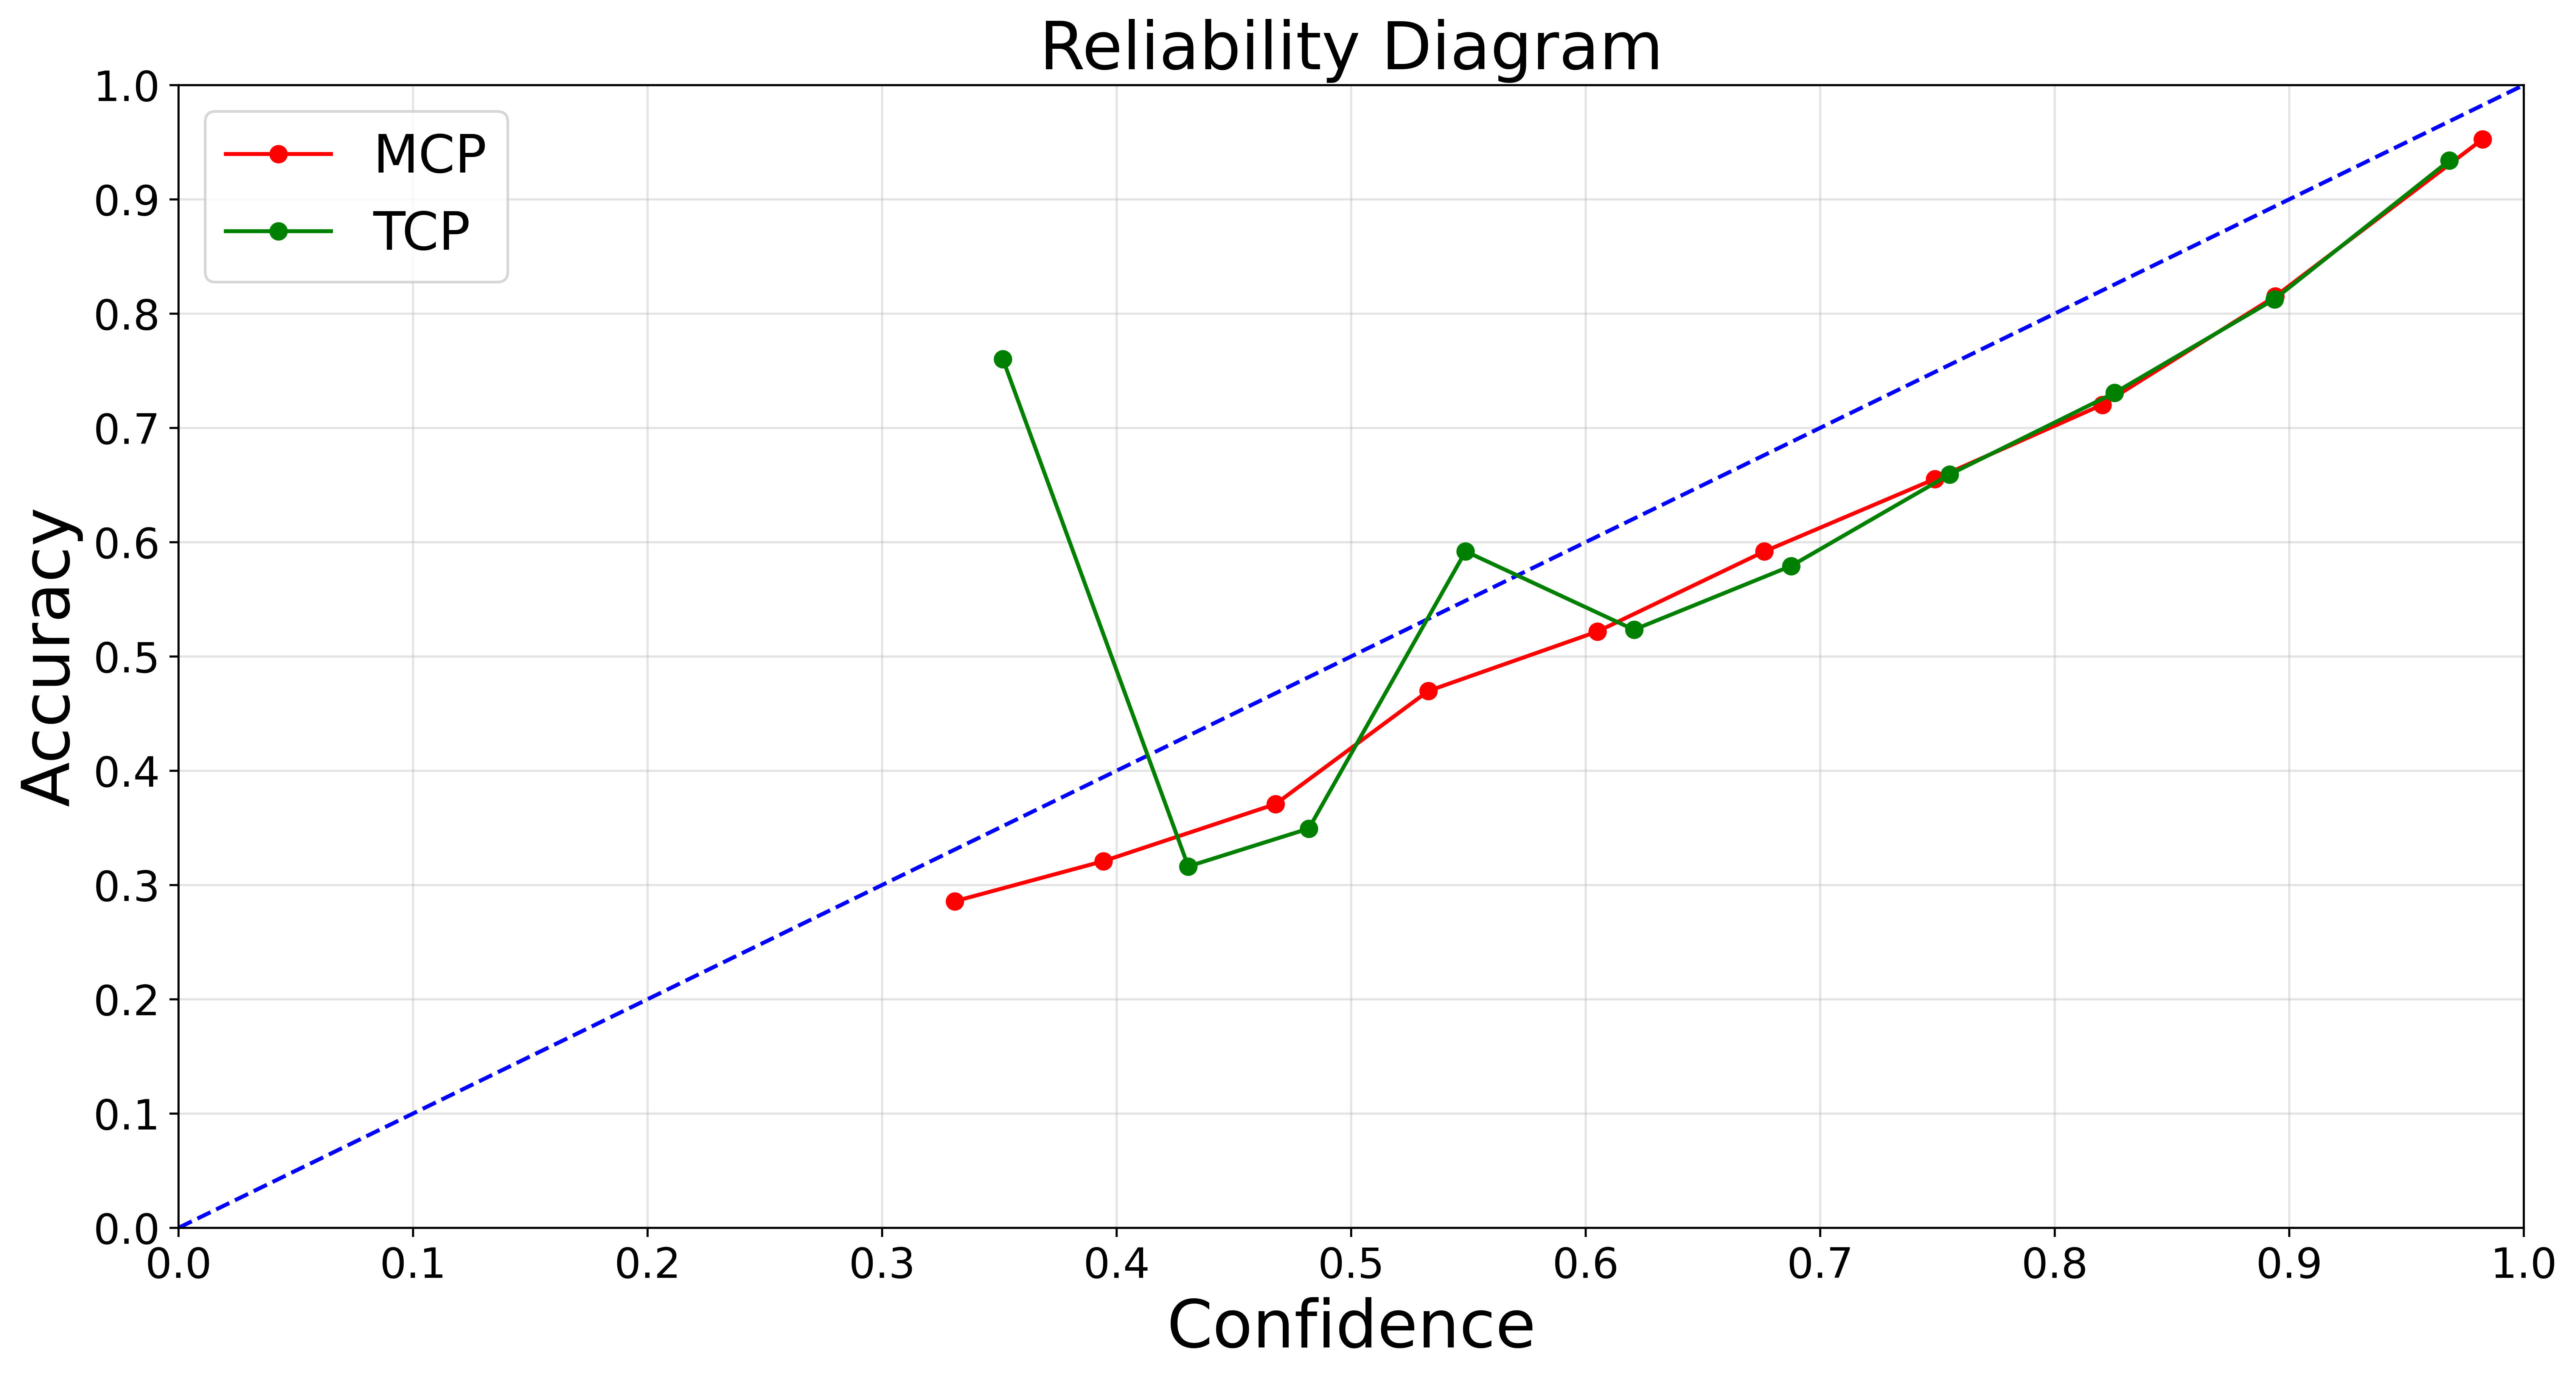

In [7]:
file_to_load = 'exp2_1_25_mae'
path = '/content/drive/MyDrive/prove_DSNL_keras/logs/basfit_tfdataset_compl_nomix_aug/models/'
experiment = np.load(path+file_to_load+'.npz')

#exp1
# config = conf_model1.get_config()
# cust = get_custom_objects()
# conf_prediction_test1 = conf_model1.predict(X_test)
# save_config_at = log_dir +'models/'+ 'exp1_3_10_mae.npz'
# json = conf_model1.to_json()
# with open( save_config_at, 'wb') as f:
#   np.savez(
#       f,
#       conf_prediction_test1,
#       history,
#       config,
#       json
#   )

#exp2
# config2 = conf_model1.get_config()
# cust2 = get_custom_objects()
# conf_prediction_test2 = conf_model1.predict(X_test)
# save_config_at = log_dir +'models/'+ 'exp2_2_10_mae.npz'
# json2 = conf_model1.to_json()

# with open( save_config_at, 'wb') as f:
#   np.savez(
#       f,
#       conf_prediction_test1,
#       history1,
#       config1,
#       json1,
#       conf_prediction_test2,
#       history2,
#       config2,
#       json2
#   )

confidence = experiment['arr_4']
confidence = confidence[:,0]
path_salvataggio = '/content/drive/MyDrive/prove_DSNL_keras/risultati/'
salvataggio_tot = path_salvataggio + file_to_load +'_tot.xlsx'
salvataggio_tot_img = path_salvataggio +'c4_'+ file_to_load +'_tot.png'

salvataggio_cla = path_salvataggio + file_to_load +'_class.xlsx'
salvataggio_cla_img = path_salvataggio + 'c4_'+ file_to_load +'_class.png'

ece_tot = ece_overall(y_test, y_test_pred, confidence, salvataggio_tot_img,  n_bins=10,fixed_bins=True)
ece_tot.to_excel(salvataggio_tot, index=False)

ece_class = ece_perclass(y_test, y_test_pred, confidence, class_names,salvataggio_cla_img, n_bins=10,fixed_bins=True)
ece_class.to_excel(salvataggio_cla)

# kde_mcp(y_test, y_test_pred, confidence, class_names)

salvataggio_tcp_cla = path_salvataggio + 'c4_'+file_to_load +'_tcp'
kde_tcp(y_test, y_test_pred, confidence, class_names, salvataggio_tcp_cla)

ece tcp  0.021053698507959812
ece tcp  0.01959985668220937
ece tcp  0.021669725957244344
ece mcp  0.06344467809678028


(array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ]),
 <a list of 11 Text major ticklabel objects>)

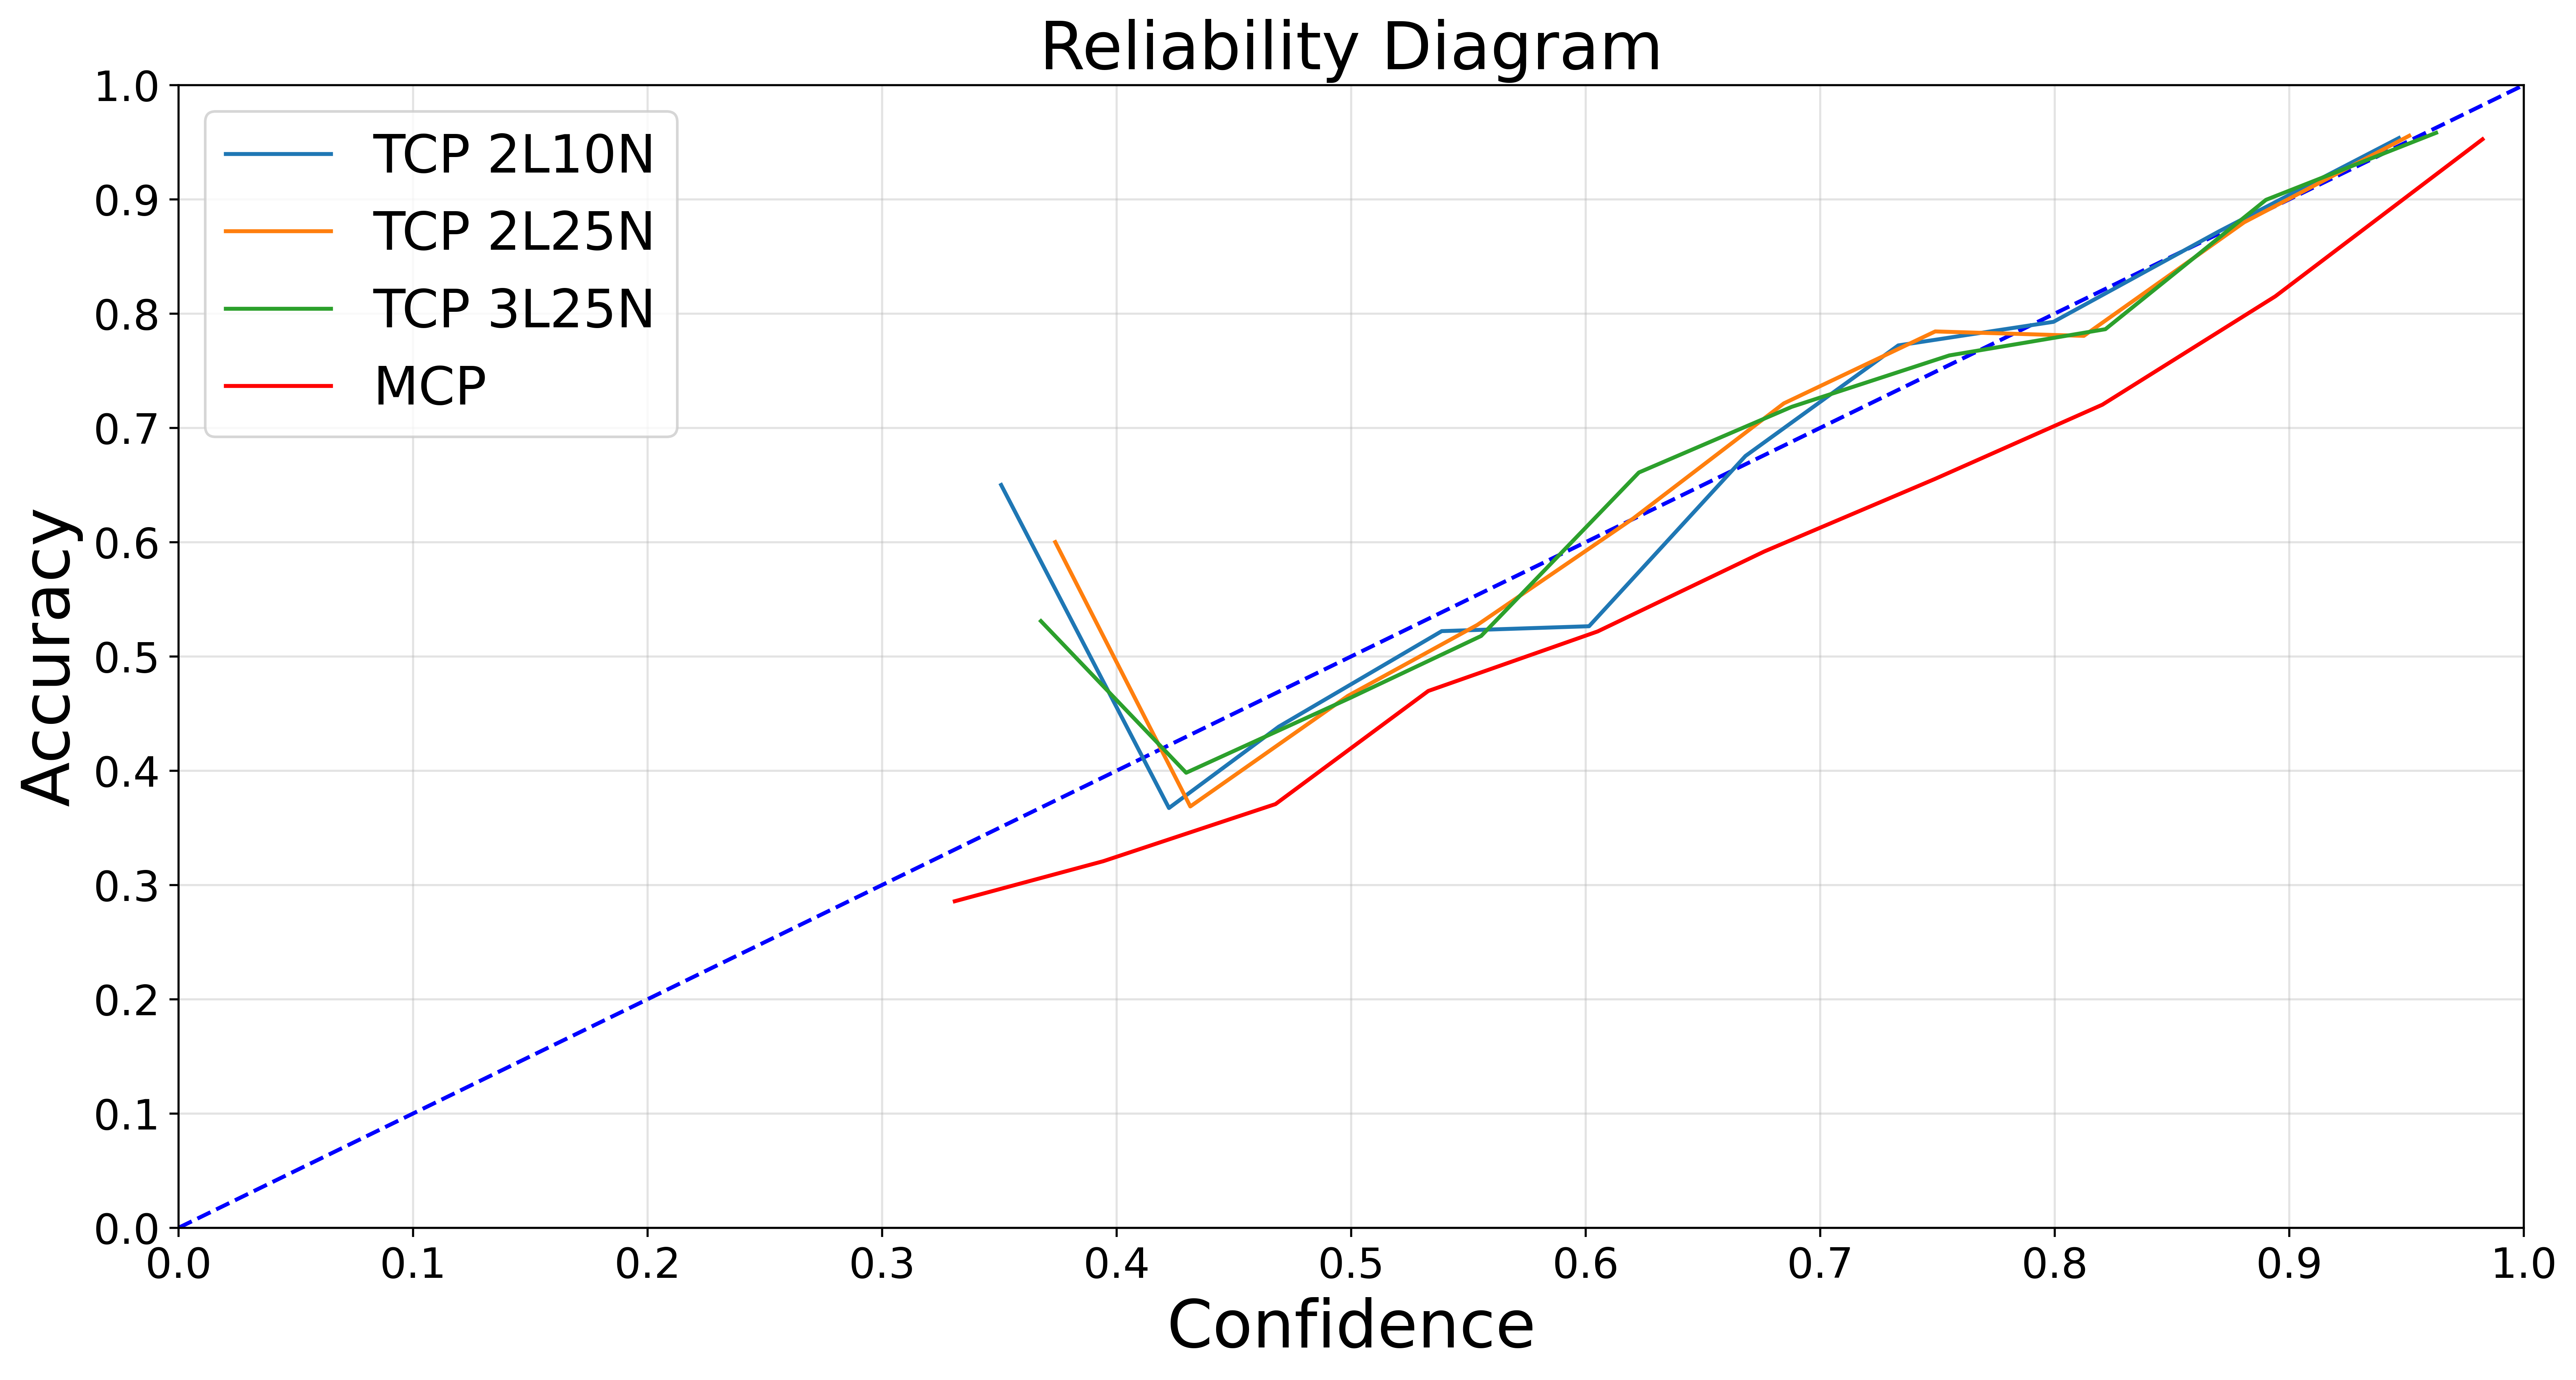

In [8]:
#confronto ece overall

file_list = [
    # 'exp2_1_10_mse',
    'exp2_2_10_mse',
    # 'exp2_3_10_mae',
    # 'exp2_3_10_mse',
    # 'exp2_1_5_mse',
    # 'exp2_2_5_mse',
    # 'exp2_3_5_mse',
    'exp2_2_25_mse',
    'exp2_3_25_mse'
]
n_bins=10

#ece
data = pd.DataFrame(y_test_pred)
data['y'] = y_test.argmax(axis=1)
data['y_cap'] = y_test_pred.argmax(axis=1)
# data['tcp'] = y_tcp_test
data['mcp'] = y_test_pred.max(axis=1)
data['bin_mcp'] = pd.cut(data['mcp'],bins=n_bins,precision=6,labels=list(np.arange(n_bins)))

fig = plt.figure(figsize=(16,8),dpi=500)
plt.plot(np.arange(0.0,1.1,0.1),np.arange(0.0,1.1,0.1),'b--')

# confidences = []
for file_to_load in file_list:
  path = '/content/drive/MyDrive/prove_DSNL_keras/logs/basfit_tfdataset_compl_nomix_aug/models/'
  experiment = np.load(path+file_to_load+'.npz')
  confidence = experiment['arr_4']
  confidence = confidence[:,0]
  data[file_to_load] = confidence
  data[f'bin_{file_to_load}'] = pd.cut(data[file_to_load],bins=n_bins,precision=6,labels=list(np.arange(n_bins)))
  # confidences.append(confidence)

  #tcp
  acc_tcp, conf_tcp, nbs_tcp = [], [], []
  for i in range(n_bins):
    bin = data[data[f'bin_{file_to_load}']==i]
    if len(bin)!= 0:
      nbs_tcp.append(len(bin))
      acc_tcp.append(len(bin.loc[bin['y']==bin['y_cap']])/len(bin))
      conf_tcp.append(np.mean(bin[file_to_load]))
    else: #TODO, without fixed bins, what parameters assing
        print('bin vuoto!!!!!!!!!!!')
        acc_tcp.append(0.2)
        conf_tcp.append(0)
        nbs_tcp.append(1000)

  ece_tcp = np.sum(np.array(nbs_tcp) * abs(np.array(acc_tcp)-np.array(conf_tcp))/len(data))
  print('ece tcp ', ece_tcp)
  if len(file_to_load ) == 12:
    plt.plot(conf_tcp,acc_tcp,label=f'TCP {file_to_load[5]}L{file_to_load[7]}N')
  else:
    plt.plot(conf_tcp,acc_tcp,label=f'TCP {file_to_load[5]}L{file_to_load[7:9]}N')
# y_test = labels
# y_test_pred = softmax_pred
# y_tcp_test = confidence
# if fixed_bins == False:



# for 
  
#   data['bin_tcp'] = pd.cut(data['tcp'],bins=n_bins,precision=6,labels=list(np.arange(n_bins)))
# if fixed_bins:
#   data['bin_mcp'] = pd.cut(data['mcp'],bins=n_bins,precision=6,labels=list(np.arange(n_bins)))
#   data['bin_tcp'] = pd.cut(data['tcp'],bins=n_bins,precision=6,labels=list(np.arange(n_bins)))
# else:
#   data['bin_mcp'] = pd.cut(data['mcp'],bins=list(np.arange(0.0,1.1,1/n_bins)),precision=6,labels=list(np.arange(n_bins)))
#   data['bin_tcp'] = pd.cut(data['tcp'],bins=list(np.arange(0.0,1.1,1/n_bins)),precision=6,labels=list(np.arange(n_bins)))

#mcp
acc_mcp, conf_mcp, nbs_mcp = [], [], []
for i in range(n_bins):
  bin = data[data['bin_mcp']==i]
  nbs_mcp.append(len(bin))
  if len(bin) != 0:
    acc_mcp.append(len(bin.loc[bin['y']==bin['y_cap']])/len(bin))
    conf_mcp.append(np.mean(bin['mcp']))
  else: #TODO, without fixed bins, what parameters assing
    acc_mcp.append(0.2)
    conf_mcp.append(0)
    nbs_mcp.append(1000)

ece_mcp = np.sum(np.array(nbs_mcp) * abs(np.array(acc_mcp)-np.array(conf_mcp))/len(data))
print('ece mcp ', ece_mcp)

plt.plot(conf_mcp,acc_mcp,'r',label='MCP')
plt.xlabel("Confidence", fontsize=25)
plt.ylabel("Accuracy", fontsize=25)
plt.xticks(np.arange(0,1.1,0.1))
plt.yticks(np.arange(0,1.1,0.1))
plt.gca().set_xlim(0,1)
plt.gca().set_ylim(0,1)
plt.title(f'Reliability Diagram', fontsize=25)
plt.legend(prop={'size': 20})
plt.grid(alpha=0.35)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)


# plt.savefig(saving_path)

# d={'ece_mcp':ece_mcp,'ece_tcp':ece_tcp}

# return pd.DataFrame([d])

In [7]:
weights_list ={
    'exp2_1_5_mae' : '2022_11_07-1855.h5',
    'exp2_2_5_mae' : '2022_11_07-2326.h5',
    'exp2_3_5_mae' : '2022_11_08-1207.h5',
    'exp2_1_10_mae' : '2022_11_06-2057.h5',
    'exp2_2_10_mae' : '2022_11_06-2257.h5',
    'exp2_3_10_mae' : '2022_11_07-0056.h5',
    'exp2_1_25_mae' : '2022_11_08-1632.h5',
    'exp2_2_25_mae' : '2022_11_08-1400.h5',
    'exp2_3_25_mae' : '2022_11_08-0616.h5',
    'exp2_1_5_mse' : '2022_11_07-2154.h5',
    'exp2_2_5_mse' : '2022_11_08-0216.h5',
    'exp2_3_5_mse' : '2022_11_08-1302.h5',
    'exp2_1_10_mse' : '2022_11_06-2158.h5',
    'exp2_2_10_mse' : '2022_11_07-0005.h5',
    'exp2_3_10_mse' : '2022_11_07-0231.h5',
    'exp2_1_25_mse' : '2022_11_08-1831.h5',
    'exp2_2_25_mse' : '2022_11_08-1538.h5',
    'exp2_3_25_mse' : '2022_11_08-0759.h5',

}
tcp_models = list(weights_list.keys())

In [6]:
def custom_act01(x,target_min=0.,target_max=1.):
  # mapping_to_target_range
    x02 = BK.tanh(x) + 1  # x in range(0,2)
    scale = (target_max - target_min) / 2.
    return x02 * scale + target_min

def load_model(file_name, weights_list):
  file_to_load = file_name
  path = '/content/drive/MyDrive/prove_DSNL_keras/logs/basfit_tfdataset_compl_nomix_aug/models/'
  experiment = np.load(path+file_to_load+'.npz')
  json = experiment['arr_3']
  model = tf.keras.models.model_from_json(str(json), custom_objects={'custom_act01':custom_act01})
  model.load_weights('/content/drive/MyDrive/prove_DSNL_keras/logs/basfit_tfdataset_compl_nomix_aug/models/'+weights_list[file_name])
  return model

In [19]:
#accuracy confidence correlation vector per patience
from sklearn.metrics import plot_confusion_matrix, f1_score
from data_prep import *
%cd /content/drive/MyDrive/prove_DSNL_keras/
import keras.backend as BK
def custom_act01(x,target_min=0.,target_max=1.):
  # mapping_to_target_range
    x02 = BK.tanh(x) + 1  # x in range(0,2)
    scale = (target_max - target_min) / 2.
    return x02 * scale + target_min

file_to_load = 'exp2_2_10_mse'
path = '/content/drive/MyDrive/prove_DSNL_keras/logs/basfit_tfdataset_compl_nomix_aug/models/'
experiment = np.load(path+file_to_load+'.npz')
json = experiment['arr_3']
conf_model = tf.keras.models.model_from_json(str(json), custom_objects={'custom_act01':custom_act01})
conf_model.load_weights('/content/drive/MyDrive/prove_DSNL_keras/logs/basfit_tfdataset_compl_nomix_aug/models/2022_11_07-0005.h5')
acc_per_patient = []
confidence_per_patience_tcp = []
confidence_per_patience_mcp = []
f1_macro = []
f1_class = []
f1_weighted = []
new_file_list_test.sort()


# for i in range(0,len(new_file_list_test),2):
for i in new_file_list_test:
  # file_list_temp = [new_file_list_test[i],new_file_list_test[i+1]]
  file_list_temp = [i]
  X_test, y_test = dp.get_seq(file_list_temp)
  print(file_list_temp)

  with tf.device('gpu'):
    gc.collect()
  y_test_pred = base_model.predict(X_test)
  tcp = conf_model.predict(X_test)
  tcp = tcp[:,0]

  matrix = confusion_matrix(np.argmax(y_test,axis=1), np.argmax(y_test_pred,axis=1))
  acc_per_patient.append(np.mean(matrix.diagonal()/matrix.sum(axis=1)))
  f1_macro.append(f1_score(y_test.argmax(axis=1), y_test_pred.argmax(axis=1),average='macro'))
  f1_class.append(f1_score(y_test.argmax(axis=1), y_test_pred.argmax(axis=1),average=None))
  f1_weighted.append(f1_score(y_test.argmax(axis=1), y_test_pred.argmax(axis=1),average='weighted'))
  mcp = np.max(y_test_pred,axis=1)
  confidence_per_patience_mcp.append(np.median(mcp))
  confidence_per_patience_tcp.append(np.median(tcp))
  # acc_per_class = list(matrix.diagonal()/matrix.sum(axis=1))
  # acc_per_class.append(np.mean(matrix.diagonal()/matrix.sum(axis=1)))

  # print(matrix.diagonal()/matrix.sum(axis=1))
  # print(matrix)

/content/drive/MyDrive/prove_DSNL_keras
1
['SC4071E0.npz']
31/31 [==============================] - 1s 19ms/step
1
['SC4072E0.npz']
40/40 [==============================] - 0s 3ms/step
1
['SC4091E0.npz']
36/36 [==============================] - 0s 4ms/step
1
['SC4092E0.npz']
35/35 [==============================] - 0s 10ms/step
1
['SC4141E0.npz']
32/32 [==============================] - 0s 8ms/step
1
['SC4142E0.npz']
30/30 [==============================] - 0s 3ms/step
1
['SC4261F0.npz']
50/50 [==============================] - 0s 3ms/step
1
['SC4262F0.npz']
31/31 [==============================] - 0s 3ms/step
1
['SC4501E0.npz']
42/42 [==============================] - 0s 8ms/step
1
['SC4502E0.npz']
35/35 [==============================] - 0s 4ms/step
1
['SC4561F0.npz']
39/39 [==============================] - 0s 3ms/step
1
['SC4562F0.npz']
36/36 [==============================] - 0s 3ms/step
1
['SC4611E0.npz']
52/52 [==============================] - 1s 14ms/step
1
['SC4612E0.npz']
34

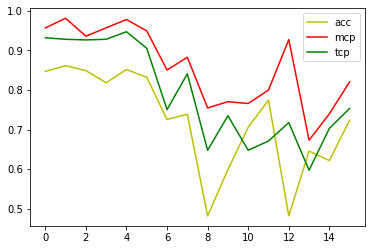

In [20]:
# acc_per_patient[2] =0.60
plt.plot(np.array(acc_per_patient),'y', label='acc')
plt.plot(np.array(confidence_per_patience_mcp),'r',label='mcp')
plt.plot(np.array(confidence_per_patience_tcp),'g',label='tcp')
plt.legend()

In [52]:
from scipy.stats.stats import pearsonr
print('Correlation ACC - MCP ' , pearsonr(np.array(acc_per_patient),np.array(confidence_per_patience_mcp)))
print('Correlation ACC - TCP ' , pearsonr(np.array(acc_per_patient),np.array(confidence_per_patience_tcp)))

print('Correlation wf1 - MCP ' , pearsonr(np.array(f1_weighted),np.array(confidence_per_patience_mcp)))
print('Correlation wf1 - TCP ' , pearsonr(np.array(f1_weighted),np.array(confidence_per_patience_tcp)))

print('Correlation mf1 - MCP ' , pearsonr(np.array(f1_macro),np.array(confidence_per_patience_mcp)))
print('Correlation mf1 - TCP ' , pearsonr(np.array(f1_macro),np.array(confidence_per_patience_tcp)))

f1_class_df = pd.DataFrame(f1_class, columns=class_names)
for i in range(len(class_names)):
  print(f'Correlation f1 {class_names[i]} - MCP ' , pearsonr(f1_class_df[class_names[i]],np.array(confidence_per_patience_mcp)))
  print(f'Correlation f1 {class_names[i]} - TCP ' , pearsonr(f1_class_df[class_names[i]],np.array(confidence_per_patience_tcp)))

Correlation ACC - MCP  (0.6272645392149678, 0.009297473122565462)
Correlation ACC - TCP  (0.767773053453378, 0.0005151123709168182)
Correlation wf1 - MCP  (0.6051737980536205, 0.012994400058667999)
Correlation wf1 - TCP  (0.8089768214858115, 0.00014770854046349959)
Correlation mf1 - MCP  (0.5309812850235478, 0.03431666839578868)
Correlation mf1 - TCP  (0.7055176556406788, 0.002263014378316569)
Correlation f1 W - MCP  (0.6339551528602544, 0.00836029103710733)
Correlation f1 W - TCP  (0.5373945457838829, 0.03181109268952981)
Correlation f1 N1 - MCP  (0.020234013038222476, 0.9407099440357655)
Correlation f1 N1 - TCP  (0.02748256038436328, 0.9195257798569267)
Correlation f1 N2 - MCP  (0.31407774760808627, 0.23614485595187237)
Correlation f1 N2 - TCP  (0.6118281350092324, 0.011777242527947122)
Correlation f1 N3 - MCP  (0.5766884442044273, 0.01935860096470902)
Correlation f1 N3 - TCP  (0.6480944161978615, 0.006625688838641448)
Correlation f1 REM - MCP  (0.3520875575284096, 0.1810878078760379

In [11]:
#ROC
from sklearn.metrics import roc_curve, roc_auc_score, recall_score, precision_score, auc, recall_score
from sklearn.metrics import f1_score, average_precision_score, roc_curve, precision_recall_curve
from data_prep import *

X_test, y_test = dp.get_seq(new_file_list_test)
print(new_file_list_test)
with tf.device('gpu'):
  gc.collect()
y_test_pred = base_model.predict(X_test)

predtest_df = pd.DataFrame(y_test_pred, columns= class_names)
predtest_df['y_cap'] = y_test_pred.argmax(axis=1)
predtest_df['y'] = y_test.argmax(axis=1) #argmax because y_train is one hot encoded


1
['SC4261F0.npz', 'SC4262F0.npz', 'SC4501E0.npz', 'SC4502E0.npz', 'SC4561F0.npz', 'SC4562F0.npz', 'SC4611E0.npz', 'SC4612E0.npz', 'SC4801G0.npz', 'SC4071E0.npz', 'SC4072E0.npz', 'SC4091E0.npz', 'SC4092E0.npz', 'SC4141E0.npz', 'SC4142E0.npz', 'SC4802G0.npz']
593/593 [==============================] - 6s 10ms/step


In [17]:
# fig = plt.figure(figsize=(20,10))

# vector_roc_truefalse = np.argmax(y_test,axis=1) == np.argmax(y_test_pred,axis=1)
vector_roc_truefalse = predtest_df['y'] == predtest_df['y_cap']

fpr_mcp, tpr_mcp, thresholds_tcp = roc_curve(vector_roc_truefalse, y_test_pred.max(axis=1))
auroc_mcp = auc_(fpr_mcp,tpr_mcp)
print('auroc_mcp ',auroc_mcp)

pre_mcp, rec_mcp, thresholds_tcp = precision_recall_curve(vector_roc_truefalse, y_test_pred.max(axis=1))
auprc_mcp = auc_(pre_mcp,rec_mcp)
print('auprc_mcp ',auprc_mcp)

for i in range(len(class_names)):
  data = predtest_df.loc[predtest_df['y']==i]
  temp_roc = data['y'] == data['y_cap']

  fpr_tcp_c, tpr_tcp_c, thresholds_tcp = roc_curve(temp_roc, data['y_cap'])
  auroc_tcp_c = auc(fpr_tcp_c,tpr_tcp_c)
  print(f'auroc_mcp class {class_names[i]}',auroc_tcp_c)

  pre_tcp_c, rec_tcp_c, thresholds_tcp = precision_recall_curve(temp_roc, data['y_cap'])
  auprc_tcp_c = auc(pre_tcp_c,rec_tcp_c)
  print(f'auprc_mcp class {class_names[i]}',auprc_tcp_c)


# #caricamento modelli
# for model in tcp_models:
#   conf_model = load_model(model, weights_list)
#   y_test_tcp = conf_model.predict(X_test)

#   fpr_tcp, tpr_tcp, thresholds_tcp = roc_curve(vector_roc_truefalse, y_test_tcp[:,0])
#   auroc_tcp = auc(fpr_tcp,tpr_tcp)
#   print('auroc_tcp  = ', auroc_tcp)

#   pre_tcp, rec_tcp, tresh = precision_recall_curve(vector_roc_truefalse, y_test_tcp[:,0])
#   auprc_tcp = auc(pre_tcp,rec_tcp)
#   print('auprc_tcp  = ', auprc_tcp)

# plt.subplot(1,2,1)
# plt.plot(pre_mcp,rec_mcp, label=f' mcp auc={auc_mcp}')
# plt.plot(pre_tcp,rec_tcp, label=f' mcp auc={auc_mcp}')
# plt.subplot(1,2,2)
# plt.plot(pre_mcp,rec_mcp, label='mcp')
# plt.plot(fpr_mcp, label='fpr mcp')
# plt.plot(fpr_tcp, label='fpr tcp')

# for model in tcp_models:
#   conf_model = load_model(model, weights_list)
#   y_test_tcp = conf_model.predict(X_test)
#   temp = y_test_tcp[:,0]
#   fpr_tcp, tpr_tcp, thresholds_mcp = roc_curve(vector_roc_truefalse, temp)

#   auc_tcp = auc(fpr_tcp,tpr_tcp)
#   # plt.plot(fpr_tcp,tpr_tcp, label=f'{model} tcp auc={auc_tcp}')
#   print('auc tcp ',model, ' = ' ,auc_tcp)

# plt.legend()
# y_test.argmax(axis=1), np.argmax(y_test_pred)
# fpr_mcp, tpr_mcp, thresholds_mcp = roc_curve(vector_roc_truefalse, 1-y_test_pred.max(axis=1))
# fpr_tcp, tpr_tcp, thresholds_tcp = roc_curve(vector_roc_truefalse, 1-np.array(y_test_tcp))

auroc_mcp  0.8009309369952131
auprc_mcp  0.17891874652125828


TypeError: ignored

In [16]:
import scipy
def auc_(x, y):
  sorted_index = np.argsort(x)
  fpr_list_sorted =  np.array(x)[sorted_index]
  tpr_list_sorted = np.array(y)[sorted_index]
  return scipy.integrate.trapz(y=tpr_list_sorted, x=fpr_list_sorted)

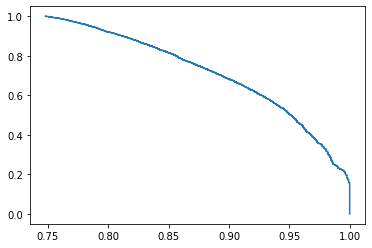

In [18]:
plt.plot(pre_mcp,rec_mcp)

In [81]:
results = pd.DataFrame(0,index=['MCP','TCP'])

ValueError: ignored

In [78]:
results

,auroc_overall


In [ ]:
from sklearn.metrics import roc_curve, roc_auc_score, recall_score, precision_score, auc, recall_score
from sklearn.metrics import f1_score, average_precision_score, roc_curve, precision_recall_curve
from data_prep import *
# fig = plt.figure(figsize=(20,10))
X_test, y_test = dp.get_seq(new_file_list_test)
print(new_file_list_test)
with tf.device('gpu'):
  gc.collect()
y_test_pred = base_model.predict(X_test)
y_test_tcp = conf_model.predict(X_test)

soglia = 0.5
pred_soglia = np.